# Dermatology Classification Problem

**Group number:** 11

* **Devora Cavaleiro** - 20230974
* **Jaime Simões** - 20230522
* **Maria Cruz** - 20230760
* **Carlos Rodrigues** - 20230543
* **Taha Attia** - 20230742

## Index

1. [Introduction](#Introduction)
2. [Import libraries](#Import-libraries)
3. [Dataset](#Dataset)
    * 3.1. [Exploring the dataset](#Exploring-the-dataset)
    * 3.2. [Variables distributions](#Variables-distributions)
4. [Data preprocessing](#Data-preprocessing)
    * 4.1. [Missing values](#Missing-values)
        * 4.1.1. [Quality control](#Quality-control)
        * 4.1.2. [Fitzpatrick scale](#Fitzpatrick-scale)
        * 4.1.3. [Images](#Images)
    * 4.2. [Encoding categorical variables](#Encoding-categorical-variables)
    * 4.3. [Encoding labels](#Encoding-labels)
5. [Split the data](#Split-the-data)
6. [Image preprocessing](#Image-preprocessing)
    * 6.1. [Image array](#Image-array)
    * 6.2. [Class balance techniques](#Class-balance-techniques)
7. [Build the model](#Build-the-model)
    * 7.1. [Hyperparameter Tuning](#Hyperparameter-Tuning)
    * 7.2. [CNN model without augmentation](#CNN-model-without-augmentation)
    * 7.3. [CNN model with augmentation](#CNN-model-with-augmentation)
    * 7.4. [CNN pre-trained model without augmentation](#CNN-pre-trained-model-without-augmentation)
8. [Results discussion](#Results-discussion)

<a id='Introduction'></a>
# 1. Introduction


In the field of dermatology, accurate diagnosis is crucial for effective treatment. However, skin condition can be tricky to identify, even for experienced doctors. Our project aims to improve skin diagnosis using a deep learning model, more specific a convolutional neural network (CNN).

The CNN are designed for object recognition, by identifying and extract patterns and features from data regardless of variations in position, orientation scale, or translation.

To achieve our model, we used different methods, first we have preprocessed the images and meta data, on this step we have filter the misleading information, and normalized the scales used and size of images, so the algorithm can understand better the information.

Furthermore, we recognized the importance of data augmentation in expanding the model's capacity to generalize across the dataset. The classes are unbalanced across the diseases diagnoses and also, we are presented with more information about lighter skin types. To overcame this, we've created more examples for the minority classes, from the existing data.

Additionally, crucial part of this project is the model selection. Using a combination of grid search and random search methodologies, we selected the optimal configuration for the model.

Last but not least, we took advantage of pre-trained models from Keras framework. This type of models has already a lot of information about different kind of images, so they help our model learn faster and better.

In short, our project aims to use deep learning to improve skin diagnosis, by combining different techniques and using pre-made programs.

In [1]:
#!rm -rf /content/project_pic

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Colab Notebooks/project_pic.zip" -d /content/
!cp "/content/drive/MyDrive/Colab Notebooks/fitzpatrick17k.csv" /content/fitzpatrick17k.csv

Streaming output truncated to the last 5000 lines.
  inflating: /content/project_pic/image_12818.jpg  
  inflating: /content/project_pic/image_7.jpg  
  inflating: /content/project_pic/image_15811.jpg  
  inflating: /content/project_pic/image_3150.jpg  
  inflating: /content/project_pic/image_5521.jpg  
  inflating: /content/project_pic/image_10969.jpg  
  inflating: /content/project_pic/image_6028.jpg  
  inflating: /content/project_pic/image_1747.jpg  
  inflating: /content/project_pic/image_52.jpg  
  inflating: /content/project_pic/image_8005.jpg  
  inflating: /content/project_pic/image_7336.jpg  
  inflating: /content/project_pic/image_1753.jpg  
  inflating: /content/project_pic/image_8011.jpg  
  inflating: /content/project_pic/image_46.jpg  
  inflating: /content/project_pic/image_7322.jpg  
  inflating: /content/project_pic/image_15805.jpg  
  inflating: /content/project_pic/image_3144.jpg  
  inflating: /content/project_pic/image_5535.jpg  
  inflating: /content/project_pic/

<a id='Import-libraries'></a>
# 2. Import libraries

In [4]:
# External libraries
import requests
from PIL import Image, UnidentifiedImageError
import os
import shutil
import io
from urllib.parse import urlparse
import re
from math import ceil
import cv2
import threading

# Data manipulation and visualization
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning frameworks
from tensorflow import keras
import tensorflow as tf
from tensorflow.compat.v1 import executing_eagerly_outside_functions, losses
from tensorflow.data import Dataset
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import f1_score

# Image processing
from skimage import filters
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<a id='Dataset'></a>
# 3. Dataset

The dataset of images was taken from the “FITZPATRICK17” repository, and is a combination of two dermatology datasets,
“DermaAmin” and “ATLAS Dermatologico”. The goal is to label the specific disease, by building a deep learning model to address this classification problem.

The dataset has the following columns:

* **md5hash:** Cryptographic hash algorithm used to generate a 128-bit digest from a string of any length.
* **fitzpatrick_scale:** Classification system based on the amount of melanin present in the skin, how the skin reacts to sun exposure, and the skin's tendency to sunburn or tan.
    * **Type I:** Very fair skin that always burns and never tans (pale or ivory skin);
    * **Type II:** Fair skin that burns easily and tans minimally (fair or light skin);
    * **Type III:** Skin that burns moderately and tans gradually to a light brown color (medium or olive skin);
    * **Type IV:** Skin that burns minimally and tans well to a moderate brown color (medium to dark brown skin);
    * **Type V:** Skin that rarely burns and tans profusely to a dark brown color (dark brown skin);
    * **Type VI:** Skin that never burns and tans very easily to a deep, dark brown or black color (deeply pigmented or black skin.
* **fitzpatrick_centaur:** Fitzpatrick classification system based in centaur's lab.
* **label:** Disease's diagnoses.
* **nine_partition_label:** Categorize diseases in 9 groups:
    * Inflammatory;
    * Benign dermal;
    * Malignant dermal;
    * Malignant melanoma;
    * Genodermatoses;
    * Malignant epidermal;
    * Benign epidermal;
    * Benign melanocyte;
    * Malignant cutaneous lymphoma.
* **three_partition_label:** Categorize diseases in 3 groups:
    * Non-neoplastic;
    * Benign;
    * Malignant.
* **qc:** quality control - indicates if the diagnose is reliable or not.
* **url:** web address pointing to the location of the image on the internet.
* **url_alphanum:** process version of the URL.


*References:*
- https://www.md5hashgenerator.com/;
- https://dermnetnz.org/topics/skin-phototype

In [5]:
df = pd.read_csv('./fitzpatrick17k.csv')
df

md5hash  fitzpatrick_scale  \
0      5e82a45bc5d78bd24ae9202d194423f8                  3   
1      fa2911a9b13b6f8af79cb700937cc14f                  1   
2      d2bac3c9e4499032ca8e9b07c7d3bc40                  2   
3      0a94359e7eaacd7178e06b2823777789                  1   
4      a39ec3b1f22c08a421fa20535e037bba                  1   
...                                 ...                ...   
16572  cd90e491ddaa92f0f4eb07f73aa09f64                  5   
16573  5f1ed6de6a9110d7dc580a6a0312af63                  4   
16574  f198aaf1f0550c2464b285454d34926e                  3   
16575  6214de2e915835014235a1839cbc5938                 -1   
16576  5a3a4c1f0effb626b298e89c032b1d28                  2   

       fitzpatrick_centaur                            label  \
0                        3  drug induced pigmentary changes   
1                        1                  photodermatoses   
2                        3                   dermatofibroma   
3                        1                        psoriasis   
4                        1                        psoriasis   
...                    ...                              ...   
16572                    5                      scleroderma   
16573                    5                 pityriasis rosea   
16574                    3                          myiasis   
16575                    5                         vitiligo   
16576                    2                  dariers disease   

      nine_partition_label three_partition_label   qc  \
0             inflammatory        non-neoplastic  NaN   
1             inflammatory        non-neoplastic  NaN   
2            benign dermal                benign  NaN   
3             inflammatory        non-neoplastic  NaN   
4             inflammatory        non-neoplastic  NaN   
...                    ...                   ...  ...   
16572         inflammatory        non-neoplastic  NaN   
16573         inflammatory        non-neoplastic  NaN   
16574         inflammatory        non-neoplastic  NaN   
16575         inflammatory        non-neoplastic  NaN   
16576       genodermatoses        non-neoplastic  NaN   

                                                     url  \
0      https://www.dermaamin.com/site/images/clinical...   
1      https://www.dermaamin.com/site/images/clinical...   
2      https://www.dermaamin.com/site/images/clinical...   
3      https://www.dermaamin.com/site/images/clinical...   
4      https://www.dermaamin.com/site/images/clinical...   
...                                                  ...   
16572  http://atlasdermatologico.com.br/img?imageId=4529   
16573  http://atlasdermatologico.com.br/img?imageId=5630   
16574  http://atlasdermatologico.com.br/img?imageId=4609   
16575  http://atlasdermatologico.com.br/img?imageId=7930   
16576  http://atlasdermatologico.com.br/img?imageId=1327   

                                            url_alphanum  
0      httpwwwdermaamincomsiteimagesclinicalpicmminoc...  
1      httpwwwdermaamincomsiteimagesclinicalpicpphoto...  
2      httpwwwdermaamincomsiteimagesclinicalpicdderma...  
3      httpwwwdermaamincomsiteimagesclinicalpicppsori...  
4      httpwwwdermaamincomsiteimagesclinicalpicppsori...  
...                                                  ...  
16572   httpwwwatlasdermatologicocombrimgimageId4529.jpg  
16573   httpwwwatlasdermatologicocombrimgimageId5630.jpg  
16574   httpwwwatlasdermatologicocombrimgimageId4609.jpg  
16575   httpwwwatlasdermatologicocombrimgimageId7930.jpg  
16576   httpwwwatlasdermatologicocombrimgimageId1327.jpg  

[16577 rows x 9 columns]

<a id='Exploring-the-dataset'></a>
## 3.1. Exploring the dataset

General information about the dataset, like the name of the columns, the datatype and the number of occurrences  in each column:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                16577 non-null  object
 1   fitzpatrick_scale      16577 non-null  int64 
 2   fitzpatrick_centaur    16577 non-null  int64 
 3   label                  16577 non-null  object
 4   nine_partition_label   16577 non-null  object
 5   three_partition_label  16577 non-null  object
 6   qc                     504 non-null    object
 7   url                    16536 non-null  object
 8   url_alphanum           16577 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


There are some statistics, where we can extract information like the most frequent record on each field:

In [7]:
df.describe(include ='int64').T

count      mean       std  min  25%  50%  75%  max
fitzpatrick_scale    16577.0  2.685709  1.526522 -1.0  2.0  2.0  4.0  6.0
fitzpatrick_centaur  16577.0  2.255113  1.658569 -1.0  1.0  2.0  3.0  6.0

In [8]:
df.describe(include="object").T

count unique  \
md5hash                16577  16577   
label                  16577    114   
nine_partition_label   16577      9   
three_partition_label  16577      3   
qc                       504      5   
url                    16536  16536   
url_alphanum           16577  16577   

                                                                     top  \
md5hash                                 5a3a4c1f0effb626b298e89c032b1d28   
label                                                          psoriasis   
nine_partition_label                                        inflammatory   
three_partition_label                                     non-neoplastic   
qc                                                          1 Diagnostic   
url                    http://atlasdermatologico.com.br/img?imageId=1327   
url_alphanum            httpwwwatlasdermatologicocombrimgimageId1327.jpg   

                        freq  
md5hash                    1  
label                    653  
nine_partition_label   10886  
three_partition_label  12080  
qc                       348  
url                        1  
url_alphanum               1

First column *'md5hash'* has no repeated values, since they are all unique.

We are using the images during the training associated to their index, we will drop this column.

In [9]:
df.drop(columns=['md5hash'], inplace=True)

Our target variable is the *'label'* column, that has the name of the diseases.

We have 114 different values, and some have more exposure that other, so in the next steps of preprocessing and augmentation, we will need to adjust this difference between labels.

In [10]:
df.label.unique()

array(['drug induced pigmentary changes', 'photodermatoses',
       'dermatofibroma', 'psoriasis', 'kaposi sarcoma',
       'neutrophilic dermatoses', 'granuloma annulare',
       'nematode infection', 'allergic contact dermatitis',
       'necrobiosis lipoidica', 'hidradenitis', 'melanoma',
       'acne vulgaris', 'sarcoidosis', 'xeroderma pigmentosum',
       'actinic keratosis', 'scleroderma', 'syringoma', 'folliculitis',
       'pityriasis lichenoides chronica', 'porphyria',
       'dyshidrotic eczema', 'seborrheic dermatitis', 'prurigo nodularis',
       'acne', 'neurofibromatosis', 'eczema', 'pediculosis lids',
       'basal cell carcinoma', 'pityriasis rubra pilaris',
       'pityriasis rosea', 'livedo reticularis',
       'stevens johnson syndrome', 'erythema multiforme',
       'acrodermatitis enteropathica', 'epidermolysis bullosa',
       'dermatomyositis', 'urticaria', 'basal cell carcinoma morpheiform',
       'vitiligo', 'erythema nodosum', 'lupus erythematosus',
       '

Taking value counts for *'label'* we see that the different classes have a big inbalance between them, which will be addressed later on.

In [11]:
df['label'].value_counts()

label
psoriasis                      653
squamous cell carcinoma        581
lichen planus                  491
basal cell carcinoma           468
allergic contact dermatitis    430
                              ... 
port wine stain                 59
erythema elevatum diutinum      55
xanthomas                       53
pustular psoriasis              53
pilomatricoma                   53
Name: count, Length: 114, dtype: int64

40 images have the with same *'url'*, but have different attributes.

In [12]:
duplicate_url = df.duplicated(subset=['url'])
print(duplicate_url.value_counts())

False    16537
True        40
Name: count, dtype: int64


In [13]:
print(df.iloc[:, :].duplicated().sum())

0


In the column *'nine_partition_label'* are presented the 9 categories for skin conditions.

We can see that the distribution between the classes is unbalanced.

In [14]:
df['nine_partition_label'].value_counts()

nine_partition_label
inflammatory                    10886
malignant epidermal              1352
genodermatoses                   1194
benign dermal                    1067
benign epidermal                  931
malignant melanoma                573
benign melanocyte                 236
malignant cutaneous lymphoma      182
malignant dermal                  156
Name: count, dtype: int64

In the column *'three_partition_label'* are presented the 3 categories for skin conditions.

Like in the previous case, we can see that the distribution between the classes is unbalanced.

In [15]:
df['three_partition_label'].value_counts()

three_partition_label
non-neoplastic    12080
malignant          2263
benign             2234
Name: count, dtype: int64

<a id='Variables-distributions'></a>
## 3.2. Variables distributions

The plots enforce the idea of unbalance classes, as we can see there is an even distribution on the different categorical variables.

<ipython-input-16-ac1af0a988bb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-16-ac1af0a988bb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-16-ac1af0a988bb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-16-ac1af0a988bb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-16-ac1af0a988bb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


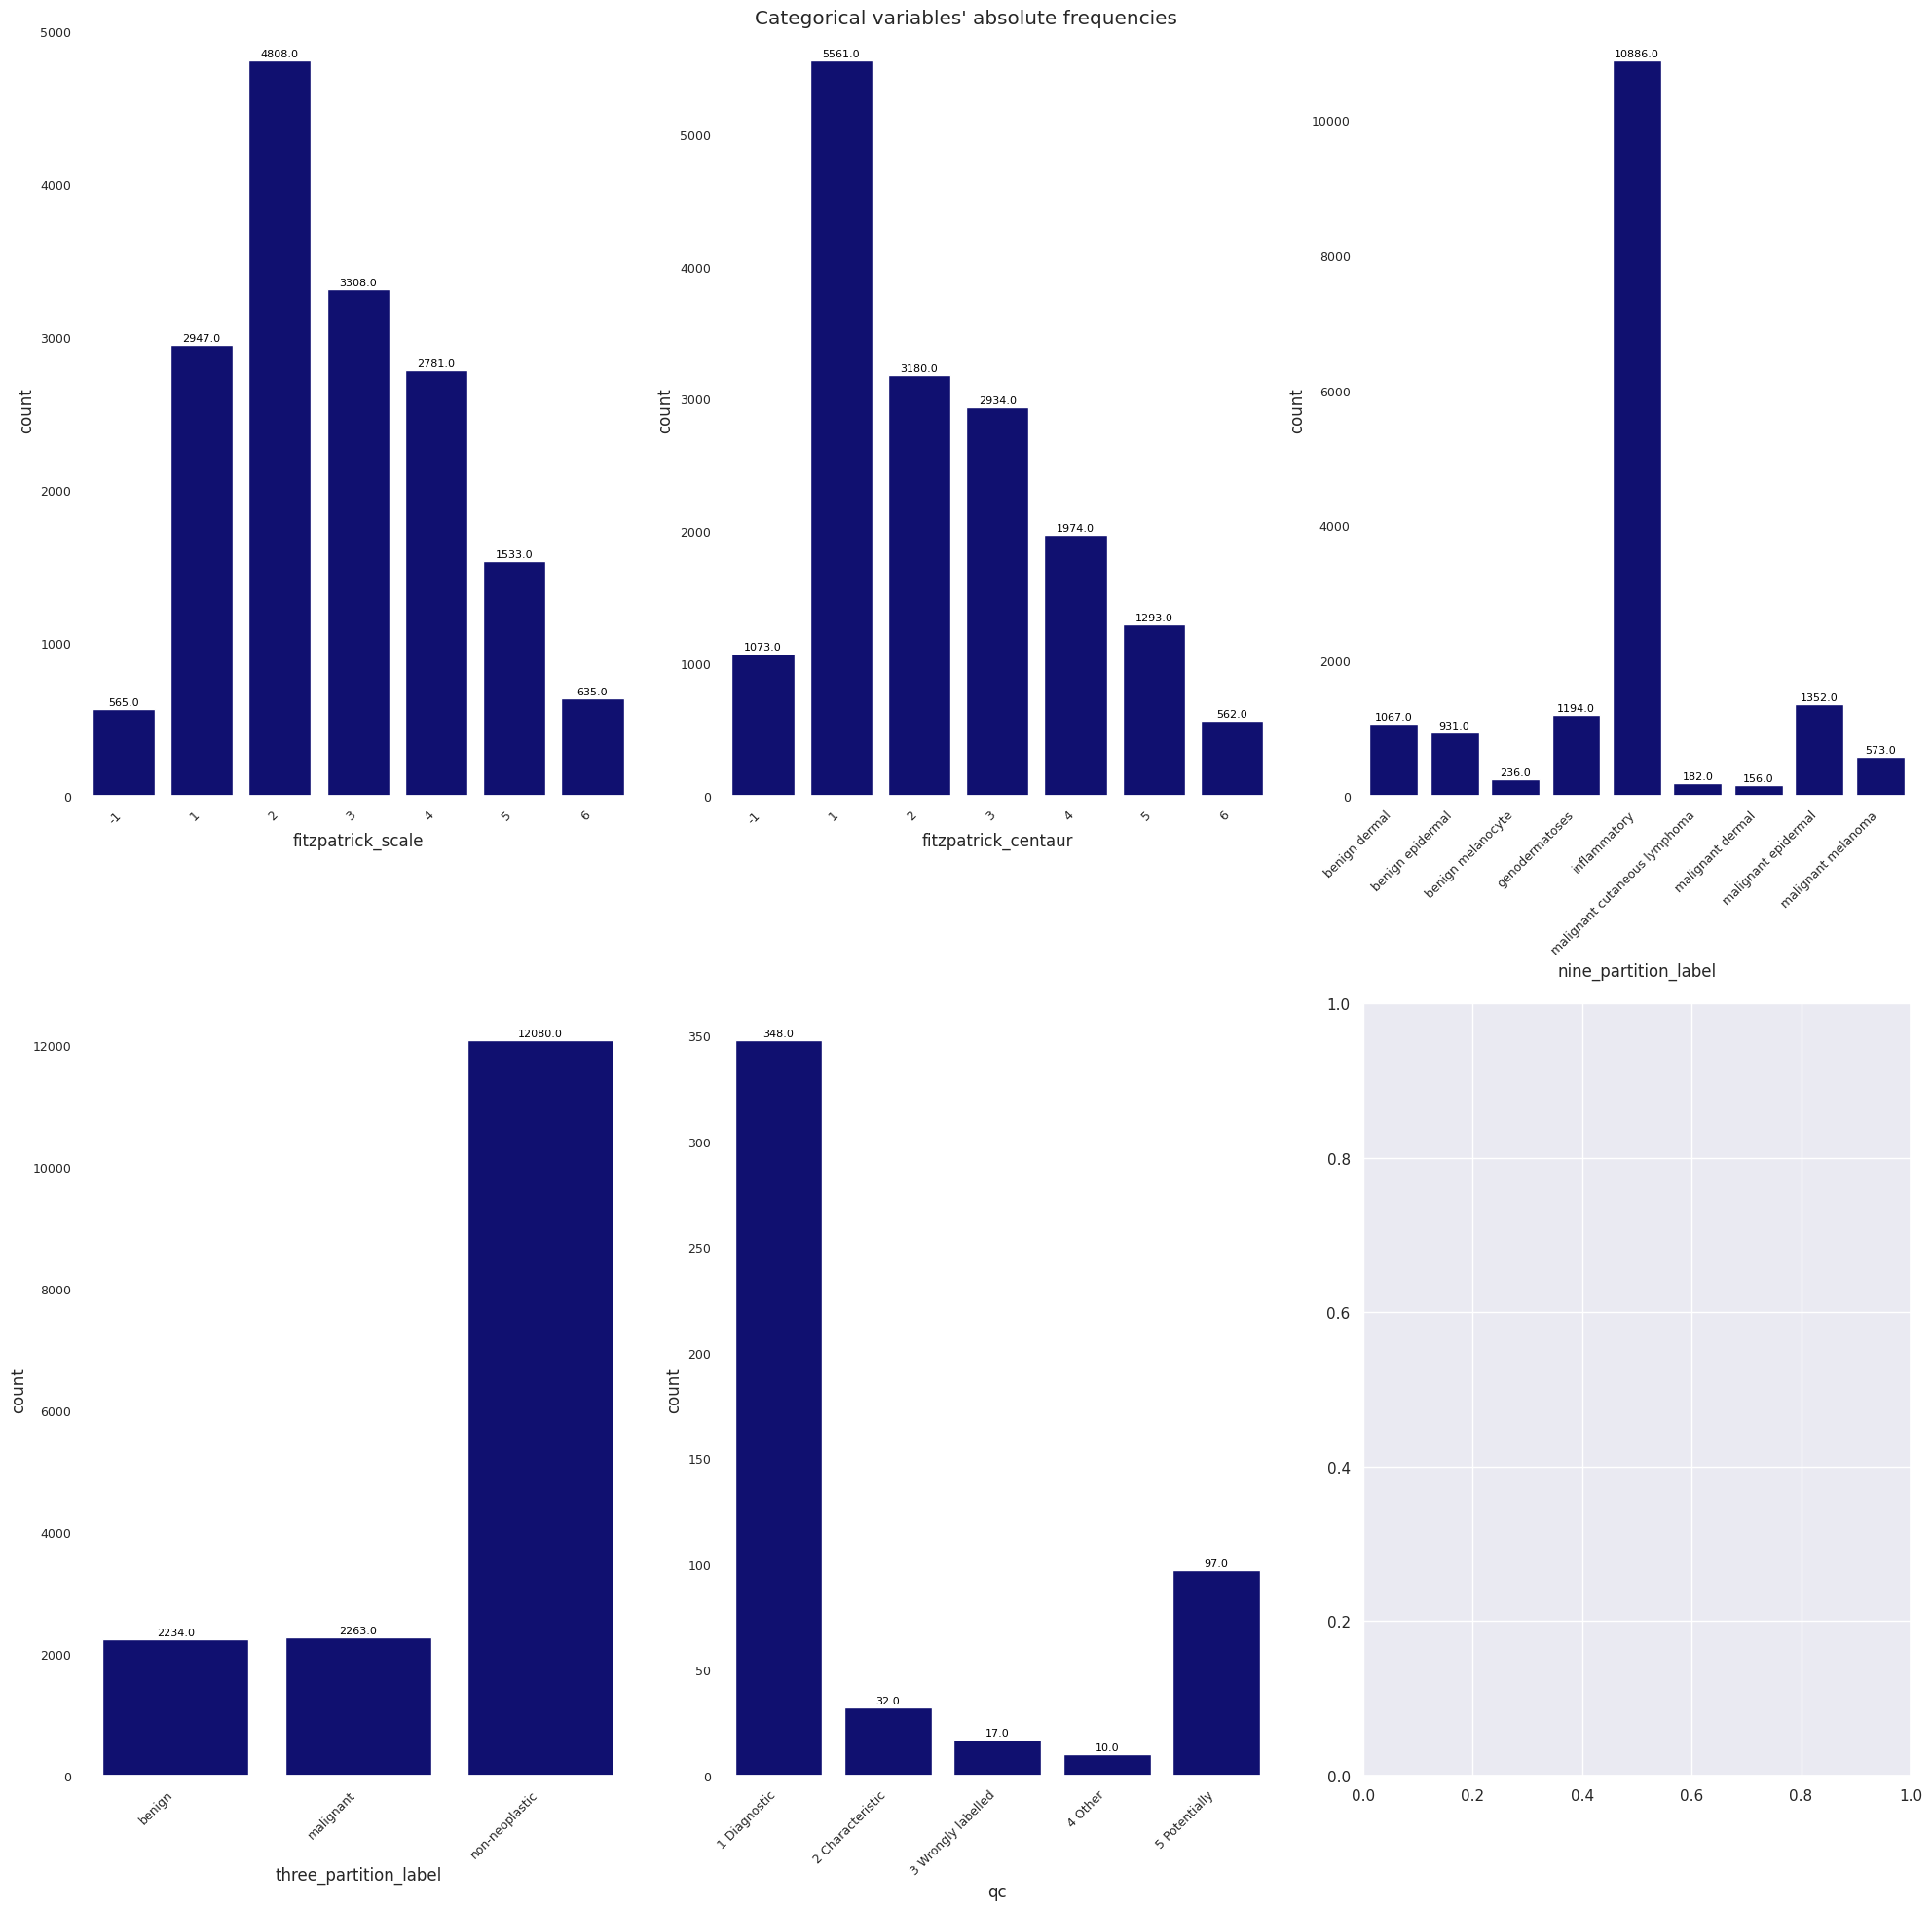

In [16]:
columns_to_visualize =['fitzpatrick_scale','fitzpatrick_centaur','nine_partition_label','three_partition_label','qc']

sns.set()
fig, axes = plt.subplots(2, ceil(len(columns_to_visualize) / 2), figsize=(20, 20))

# Plot each bar plot:
for ax, feat in zip(axes.flatten(), columns_to_visualize):
    order = df[feat].value_counts().sort_index().index
    sns.countplot(x=df[feat].astype(object), ax=ax, color='navy', order=order)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Frequence on top
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=8, color='black',
                    xytext=(0, 5),
                    textcoords='offset points')

    ax.set_facecolor('none')

title = "Categorical variables' absolute frequencies"
plt.suptitle(title)
plt.tight_layout()
plt.show()

On this dataset, there is two ways to categorize diseases: *'nine_partition_label'* and *'three_partition_label'*. If we relate these two classification categories, we can get a better understanding on what type of labels are considered benign, malignant or non-neoplastic.

**Benign category:**
* Benign dermal;
* Benign epidermal;
* Benign melanocyte.

**Malignant category:**
* Malignant epidermal;
* Malignant melanoma;
* Malignant cutaneous lymphoma;
* Malignant dermal.

**Non-neoplastic category:**
* Inflammatory;
* Genodermatoses.

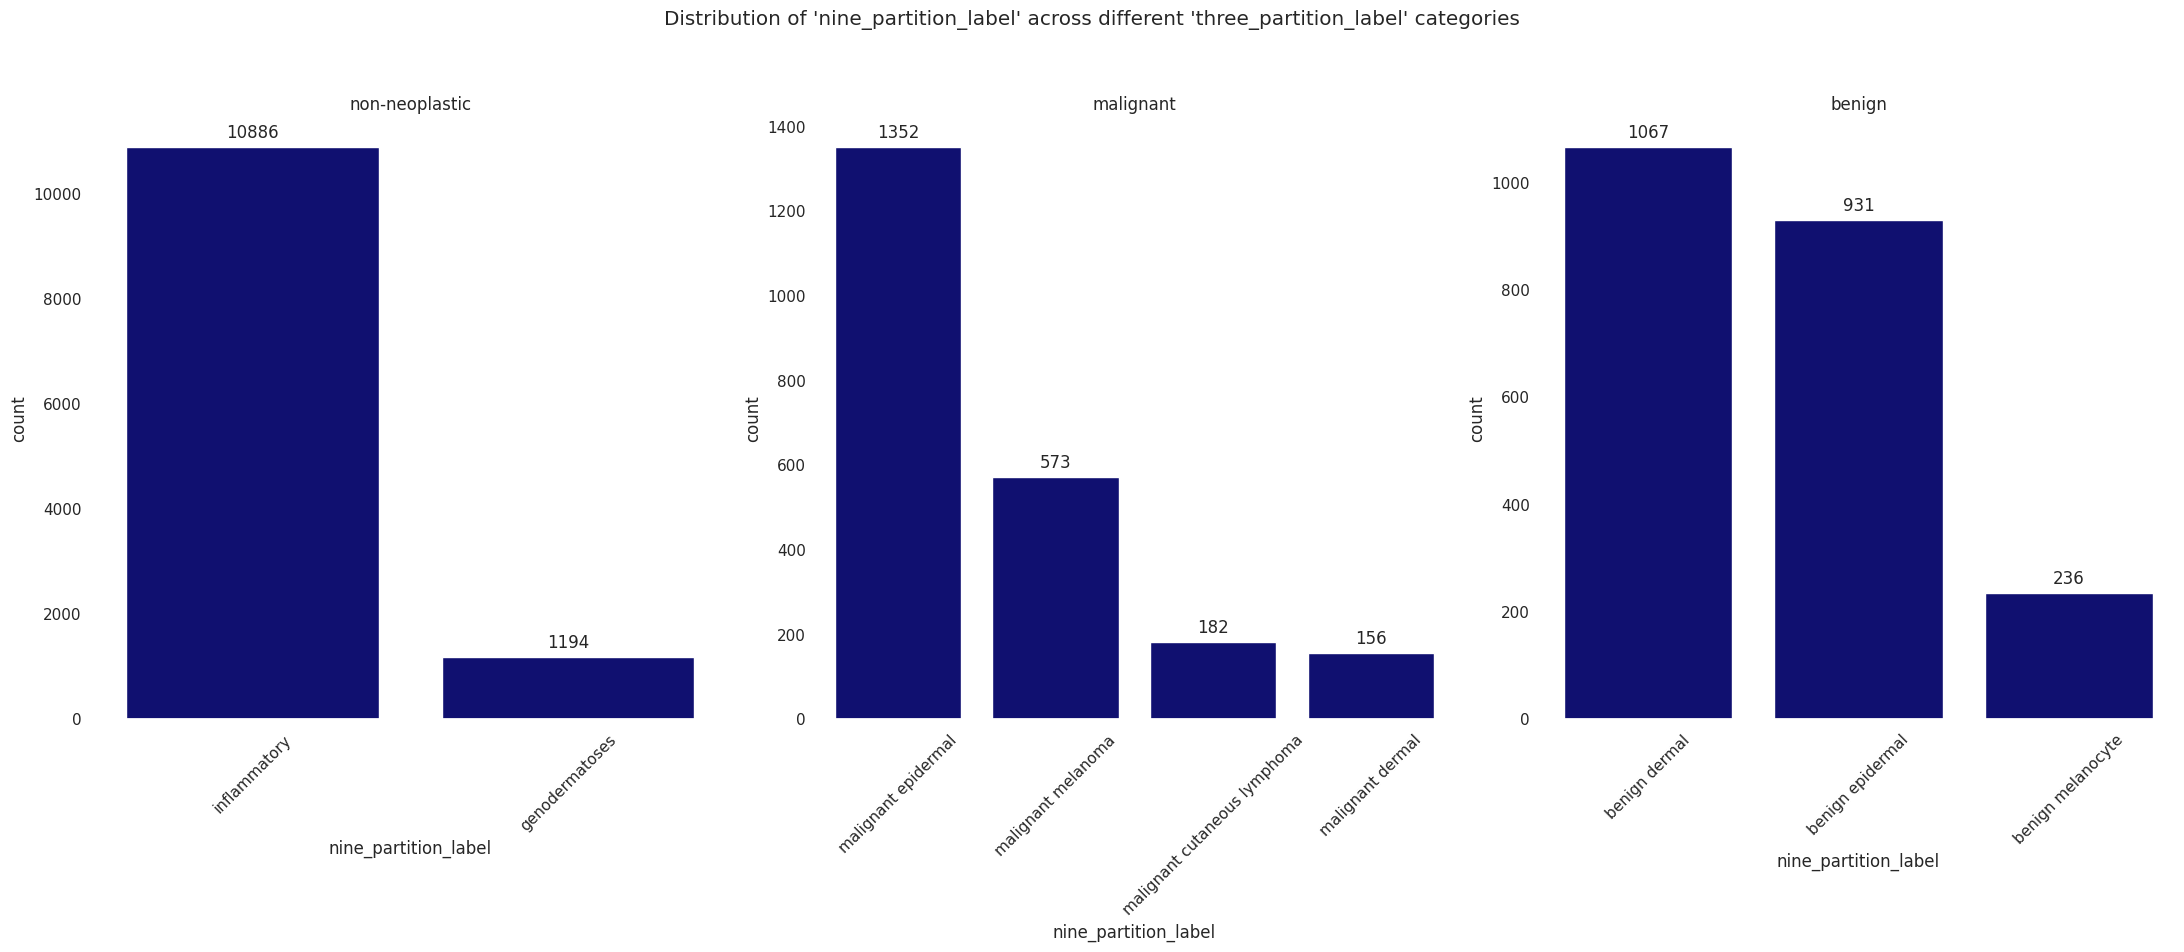

In [17]:
categories = ['non-neoplastic', 'malignant', 'benign']

fig, ax = plt.subplots(1, 3, figsize=(22, 10))
fig.suptitle("Distribution of 'nine_partition_label' across different 'three_partition_label' categories")

for i, category in enumerate(categories):
    # Filter the 'three_partition_label'
    filtered_dataset = df[df['three_partition_label'] == category]

    # Plot this condition on 'nine_partition_label'
    sns.countplot(data=filtered_dataset, x='nine_partition_label',
                  order=filtered_dataset['nine_partition_label'].value_counts().index,
                  ax=ax[i], color='navy')
    ax[i].set_title(category)
    ax[i].tick_params(axis='x', rotation=45)

    # Frequence on top
    for p in ax[i].patches:
        height = p.get_height()
        ax[i].annotate(f'{int(height)}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center',
                         xytext=(0, 10),
                         textcoords='offset points')

    ax[i].set_facecolor('none')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<a id='Data-preprocessing'></a>
# 4. Data preprocessing

<a id='Missing-values'></a>
## 4.1. Missing values

When checking for missing values, the *'qc'* is mostly empty and *'url'* has some missing values.

In [18]:
missing_values = df.isna().sum()

# Percentage of missing values
percentage_missing = (missing_values / df.shape[0]) * 100

missing_data_summary = pd.DataFrame({
    'Variable': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage Missing': percentage_missing.values
})

print(missing_data_summary)

                Variable  Missing Values  Percentage Missing
0      fitzpatrick_scale               0            0.000000
1    fitzpatrick_centaur               0            0.000000
2                  label               0            0.000000
3   nine_partition_label               0            0.000000
4  three_partition_label               0            0.000000
5                     qc           16073           96.959643
6                    url              41            0.247331
7           url_alphanum               0            0.000000


<a id='Quality-control'></a>
### 4.1.1. Quality control

There are some rows that the images are wrongly labelled, so those rows will be deleted, since they have wrong information.

In [19]:
df['qc'].value_counts()

qc
1 Diagnostic          348
5 Potentially          97
2 Characteristic       32
3 Wrongly labelled     17
4 Other                10
Name: count, dtype: int64

In [20]:
wrongly_labelled_rows = df[(df['qc'] == '3 Wrongly labelled')]
wrongly_labelled_rows

fitzpatrick_scale  fitzpatrick_centaur  \
508                    6                    6   
1588                   2                    1   
2513                   3                    2   
2674                   1                    1   
2943                   5                    4   
5045                   5                    6   
6323                   6                    5   
8187                   2                    2   
8649                   3                    2   
9315                   1                    1   
9950                   1                    1   
10089                  5                    5   
10151                  2                    2   
10802                  6                    5   
13712                  2                    1   
13715                  4                    4   
13729                  5                    5   

                                 label nine_partition_label  \
508               seborrheic keratosis     benign epidermal   
1588                     drug eruption         inflammatory   
2513                      folliculitis         inflammatory   
2674                         tick bite         inflammatory   
2943   drug induced pigmentary changes         inflammatory   
5045                        halo nevus    benign melanocyte   
6323                          vitiligo         inflammatory   
8187                  sun damaged skin         inflammatory   
8649                    telangiectases        benign dermal   
9315                            striae         inflammatory   
9950                granuloma annulare         inflammatory   
10089                             acne         inflammatory   
10151                     folliculitis         inflammatory   
10802          squamous cell carcinoma  malignant epidermal   
13712               granuloma annulare         inflammatory   
13715                   telangiectases        benign dermal   
13729          neutrophilic dermatoses         inflammatory   

      three_partition_label                  qc  \
508                  benign  3 Wrongly labelled   
1588         non-neoplastic  3 Wrongly labelled   
2513         non-neoplastic  3 Wrongly labelled   
2674         non-neoplastic  3 Wrongly labelled   
2943         non-neoplastic  3 Wrongly labelled   
5045                 benign  3 Wrongly labelled   
6323         non-neoplastic  3 Wrongly labelled   
8187         non-neoplastic  3 Wrongly labelled   
8649                 benign  3 Wrongly labelled   
9315         non-neoplastic  3 Wrongly labelled   
9950         non-neoplastic  3 Wrongly labelled   
10089        non-neoplastic  3 Wrongly labelled   
10151        non-neoplastic  3 Wrongly labelled   
10802             malignant  3 Wrongly labelled   
13712        non-neoplastic  3 Wrongly labelled   
13715                benign  3 Wrongly labelled   
13729        non-neoplastic  3 Wrongly labelled   

                                                     url  \
508    https://www.dermaamin.com/site/images/clinical...   
1588   https://www.dermaamin.com/site/images/clinical...   
2513   https://www.dermaamin.com/site/images/clinical...   
2674   https://www.dermaamin.com/site/images/clinical...   
2943   https://www.dermaamin.com/site/images/clinical...   
5045   https://www.dermaamin.com/site/images/clinical...   
6323   https://www.dermaamin.com/site/images/clinical...   
8187   https://www.dermaamin.com/site/images/clinical...   
8649   https://www.dermaamin.com/site/images/clinical...   
9315   https://www.dermaamin.com/site/images/clinical...   
9950   https://www.dermaamin.com/site/images/clinical...   
10089  https://www.dermaamin.com/site/images/clinical...   
10151  https://www.dermaamin.com/site/images/clinical...   
10802  https://www.dermaamin.com/site/images/clinical...   
13712  http://atlasdermatologico.com.br/img?imageId=2297   
13715   http://atlasdermatologico.com.br/img?imageId=808   
13729  http://atlasdermatologico.com.br/img?imageI

In [21]:
df_1 = df.copy()

In [22]:
df_1.drop(wrongly_labelled_rows.index, inplace=True)

Since the column *'qc'* has over 96% of missing values, we have considered that don't have enough information, so it will be deleted.

In [23]:
df_1.drop(columns=['qc'], inplace=True)

<a id='Fitzpatrick-scale'></a>
### 4.1.2. Fitzpatrick scale

The **Fitzpatrick scale** ranges between 1 to 6, but in this dataset, there are some labels as -1, we have assumed that these values correspond to missing information.

We decided to check exactly how many labels matched (or not) between these two columns.

In [24]:
# Match columns
df_1['fitzpatrick_scale_match'] = df_1['fitzpatrick_scale'] == df_1['fitzpatrick_centaur']

# Group by 'fitzpatrick_scale' and 'match_status', and count
grouped_counts = df_1.groupby(['fitzpatrick_scale', 'fitzpatrick_scale_match']).size().reset_index(name='count')

sorted_counts = grouped_counts.sort_values(by=['fitzpatrick_scale', 'fitzpatrick_scale_match', 'count'])

# Unique values
for label in sorted(df_1['fitzpatrick_scale'].unique()):
    display_label = sorted_counts[sorted_counts['fitzpatrick_scale'] == label]
    print(f"Skin type labeling '{label}':\n", display_label, "\n")

Skin type labeling '-1':
    fitzpatrick_scale  fitzpatrick_scale_match  count
0                 -1                    False    274
1                 -1                     True    291 

Skin type labeling '1':
    fitzpatrick_scale  fitzpatrick_scale_match  count
2                  1                    False    486
3                  1                     True   2458 

Skin type labeling '2':
    fitzpatrick_scale  fitzpatrick_scale_match  count
4                  2                    False   3247
5                  2                     True   1557 

Skin type labeling '3':
    fitzpatrick_scale  fitzpatrick_scale_match  count
6                  3                    False   2018
7                  3                     True   1288 

Skin type labeling '4':
    fitzpatrick_scale  fitzpatrick_scale_match  count
8                  4                    False   1813
9                  4                     True    967 

Skin type labeling '5':
     fitzpatrick_scale  fitzpatrick_scale_mat

In [25]:
total_observations = len(df)

# Check for matching and non-matching labels
matching_labels_count = df_1['fitzpatrick_scale_match'].sum()
non_matching_labels_count = total_observations - matching_labels_count

matching_labels_percentage = (matching_labels_count / total_observations) * 100
non_matching_labels_percentage = (non_matching_labels_count / total_observations) * 100

print(f"Percentage of matching skin-type labels: {matching_labels_percentage:.2f}%")
print(f"Percentage of non-matching skin-type labels: {non_matching_labels_percentage:.2f}%")

Percentage of matching skin-type labels: 45.70%
Percentage of non-matching skin-type labels: 54.30%


In [26]:
# Rows that are -1 in both columns
subs_true_scale = (df_1['fitzpatrick_scale'] == -1) & (df_1['fitzpatrick_centaur'] != -1)
subs_true_centaur = (df_1['fitzpatrick_centaur'] == -1) & (df_1['fitzpatrick_scale'] != -1)
total_subs_true = subs_true_scale.sum() + subs_true_centaur.sum()

subs_false = (df_1['fitzpatrick_centaur'] == -1) & (df_1['fitzpatrick_scale'] == -1)

print(f"Number of rows containing '-1' that can have that value substituted: {total_subs_true.sum()}")
print(f"Number of rows that can't have their value substituted: {subs_false.sum()}")

Number of rows containing '-1' that can have that value substituted: 1056
Number of rows that can't have their value substituted: 291


In [27]:
# Total -1 in 'fitzpatrick_scale'
total_minus_one_scale = (df_1['fitzpatrick_scale'] == -1).sum()

# Total -1 in 'fitzpatrick_centaur'
total_minus_one_centaur = (df_1['fitzpatrick_centaur'] == -1).sum()

# Select 'fitzpatrick_scale' the rows where 'fitzpatrick_scale' is -1 but 'fitzpatrick_centaur' is not
percentage_scale_subs = (subs_true_scale.sum() / total_minus_one_scale) * 100 if total_minus_one_scale > 0 else 0

# Select 'fitzpatrick_centaur' the rows where 'fitzpatrick_centaur' is -1 but 'fitzpatrick_scale' is not
percentage_centaur_subs = (subs_false.sum() / total_minus_one_centaur) * 100 if total_minus_one_centaur > 0 else 0


print(f"Percentage of substitutable '-1' values in 'fitzpatrick_scale': {percentage_scale_subs:.2f}% of the total '-1's")
print(f"Percentage of substitutable '-1' values in 'fitzpatrick_centaur': {percentage_centaur_subs:.2f}% of the total '-1's")

Percentage of substitutable '-1' values in 'fitzpatrick_scale': 48.50% of the total '-1's
Percentage of substitutable '-1' values in 'fitzpatrick_centaur': 27.12% of the total '-1's


Since the both Fitzpatrick scales represent the same concept, we will use the values present on one scale to correct the missing values on the other one.

We start to check the values on *'fitzpatrick_centaur'* to in the next steps correct them values on *'fitzpatrick_scale'*.

In [28]:
condition1 = df_1['fitzpatrick_scale'] == -1
condition2 = df_1['fitzpatrick_centaur'] != -1

# 'fitzpatrick_scale' equal to -1 and 'fitzpatrick_centaur' not equal to -1, corrected missing scale
correct_missing_fitzpatrick_scale = df_1.loc[condition1 & condition2, ['fitzpatrick_scale', 'fitzpatrick_centaur']]

print(correct_missing_fitzpatrick_scale)

       fitzpatrick_scale  fitzpatrick_centaur
57                    -1                    1
64                    -1                    1
95                    -1                    2
149                   -1                    2
188                   -1                    1
...                  ...                  ...
16436                 -1                    5
16445                 -1                    2
16448                 -1                    2
16540                 -1                    4
16575                 -1                    5

[274 rows x 2 columns]


Then, we do the same thing on the values of *'fitzpatrick_centaur'*.

In [29]:
condition3 = df_1['fitzpatrick_centaur'] == -1
condition4 = df_1['fitzpatrick_scale'] != -1

# 'fitzpatrick_centaur' equal to -1 and 'fitzpatrick_scale' not equal to -1, corrected missing scale
correct_missing_fitzpatrick_centaur = df_1.loc[condition3 & condition4, ['fitzpatrick_centaur', 'fitzpatrick_scale']]

print(correct_missing_fitzpatrick_centaur)

       fitzpatrick_centaur  fitzpatrick_scale
70                      -1                  2
77                      -1                  4
105                     -1                  2
156                     -1                  2
157                     -1                  3
...                    ...                ...
16533                   -1                  4
16545                   -1                  2
16556                   -1                  4
16559                   -1                  2
16568                   -1                  5

[782 rows x 2 columns]


Now, we do the corrections.

In [30]:
# Substitution of -1 in 'fitzpatrick_scale' with 'fitzpatrick_centaur' values
df_1.loc[condition1, 'fitzpatrick_scale'] = df_1.loc[condition1, 'fitzpatrick_centaur']

subs = condition3 & condition4

# Substitution -1 values in 'fitzpatrick_centaur' with 'fitzpatrick_scale' values
df_1.loc[subs, 'fitzpatrick_centaur'] = df_1.loc[subs, 'fitzpatrick_scale']

Plotting the results to check if the substitution was successful.

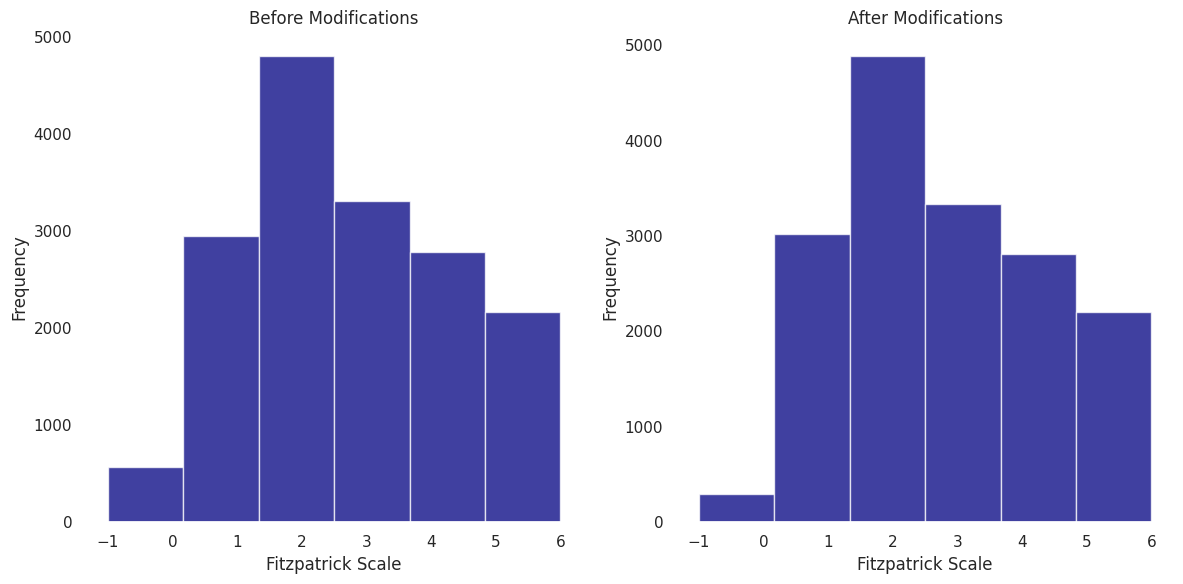

In [31]:
# 'fitzpatrick_scale'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot before modifications
df['fitzpatrick_scale'].plot(kind='hist', bins=6, alpha=0.75, ax=axs[0], color='navy')
axs[0].set_title('Before Modifications')
axs[0].set_xlabel('Fitzpatrick Scale')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', alpha=0.75)
axs[0].set_facecolor('none')

# Plot after modifications
df_1['fitzpatrick_scale'].plot(kind='hist', bins=6, alpha=0.75, ax=axs[1], color='navy')
axs[1].set_title('After Modifications')
axs[1].set_xlabel('Fitzpatrick Scale')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y', alpha=0.75)
axs[1].set_facecolor('none')

plt.tight_layout()
plt.show()

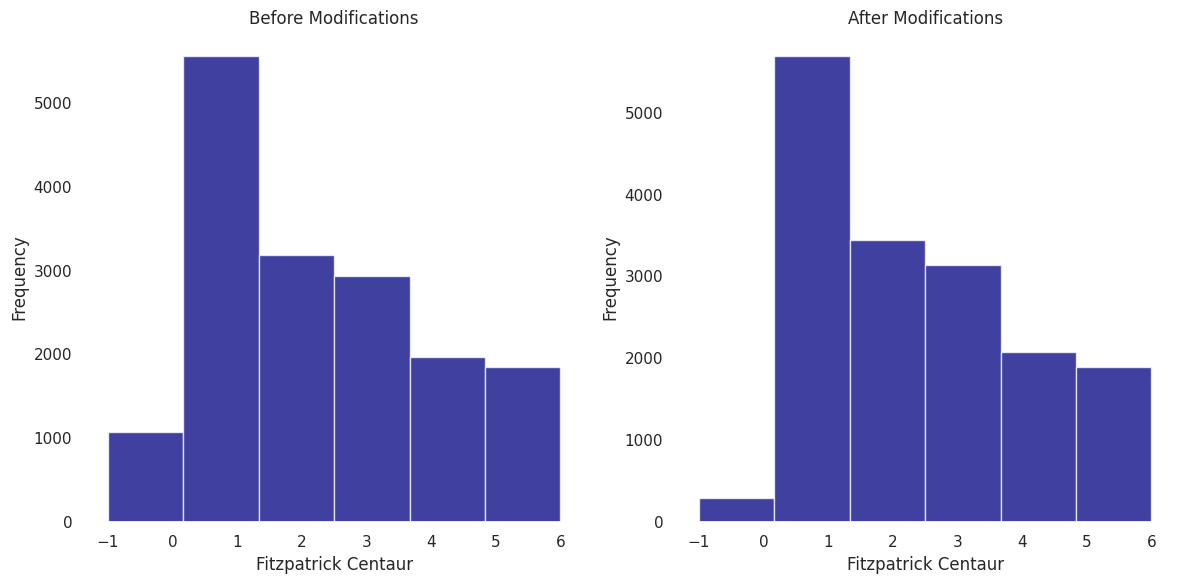

In [32]:
# 'fitzpatrick_centaur'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot before modifications
df['fitzpatrick_centaur'].plot(kind='hist', bins=6, alpha=0.75, ax=axs[0], color='navy')
axs[0].set_title('Before Modifications')
axs[0].set_xlabel('Fitzpatrick Centaur')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', alpha=0.75)
axs[0].set_facecolor('none')

# Plot after modifications
df_1['fitzpatrick_centaur'].plot(kind='hist', bins=6, alpha=0.75, ax=axs[1], color='navy')
axs[1].set_title('After Modifications')
axs[1].set_xlabel('Fitzpatrick Centaur')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y', alpha=0.75)
axs[1].set_facecolor('none')

plt.tight_layout()
plt.show()

Now, we apply mode on the rest of the missing values of both columns using a sort of nearest neighbors method, by corresponding each of those rows to the corresponding label value, and the associate missing value to the mode of all the other instances that have that same label category.

In [33]:
# Mode 'fitzpatrick_centaur'
mode_per_centaur = defaultdict(int)
for category in df_1['nine_partition_label'].unique():
    mode_value_centaur = df_1[(df_1['nine_partition_label'] == category) & (df_1['fitzpatrick_centaur'] != -1)]['fitzpatrick_centaur'].mode()
    if not mode_value_centaur.empty:
        mode_per_centaur[category] = mode_value_centaur.iloc[0]

# Fill -1
for category, mode_value_centaur in mode_per_centaur.items():
    df_1.loc[(df_1['fitzpatrick_centaur'] == -1) & (df_1['nine_partition_label'] == category), 'fitzpatrick_centaur'] = mode_value_centaur

In [34]:
# Mode 'fitzpatrick_scale'
mode_per_scale = defaultdict(int)
for category in df_1['nine_partition_label'].unique():
    mode_value_scale = df_1[(df_1['nine_partition_label'] == category) & (df_1['fitzpatrick_scale'] != -1)]['fitzpatrick_scale'].mode()
    if not mode_value_scale.empty:
        mode_per_scale[category] = mode_value_scale.iloc[0]

# Fill -1
for category, mode_value_scale in mode_per_scale.items():
    df_1.loc[(df_1['fitzpatrick_scale'] == -1) & (df_1['nine_partition_label'] == category), 'fitzpatrick_scale'] = mode_value_scale

In [35]:
correlation = df_1["fitzpatrick_scale"].corr(df_1["fitzpatrick_centaur"])
print("Correlation between fitzpatrick_scale and fitzpatrick_centaur:", correlation)

Correlation between fitzpatrick_scale and fitzpatrick_centaur: 0.8186512632617708


Now we will merge these columns since they give the same information and have a high correlation.

In [36]:
# New column that is the average of 'fitzpatrick_scale' and 'fitzpatrick_centaur'
df_1['fitzpatrick_scale_merged'] = (df_1['fitzpatrick_scale'] + df_1['fitzpatrick_centaur']) / 2

In [37]:
df_1.drop(['fitzpatrick_scale', 'fitzpatrick_centaur', 'fitzpatrick_scale_match'], axis=1, inplace=True)
print(df_1['fitzpatrick_scale_merged'].unique())

[3.  1.  2.5 5.5 2.  1.5 4.  5.  3.5 4.5 6. ]


#### Normalization

Normalizing the values of the scale is important, because this way we prevent certain values from dominating others, leading to faster convergence during training and improvement of numerical stability.

In [38]:
scaler = MinMaxScaler()

df_1['fitzpatrick_scale_merged'] = scaler.fit_transform(df_1[['fitzpatrick_scale_merged']])

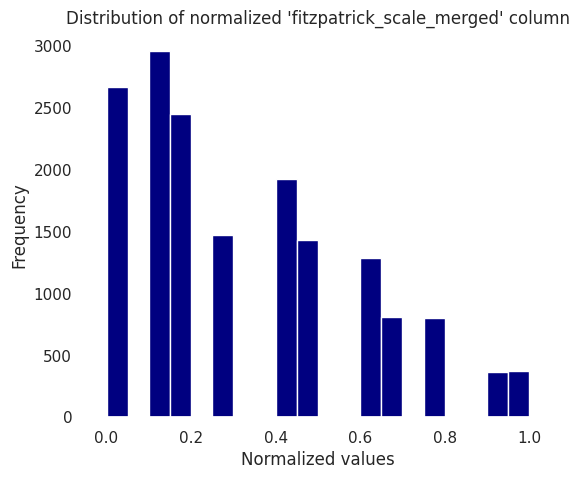

In [39]:
plt.figure(figsize=(6,5))
plt.hist(df_1['fitzpatrick_scale_merged'], bins=20, color='navy', edgecolor='white')
plt.title("Distribution of normalized 'fitzpatrick_scale_merged' column")
plt.xlabel('Normalized values')
plt.ylabel('Frequency')
plt.grid(True)
plt.gca().set_facecolor('none')
plt.show()

<a id='Images'></a>
### 4.1.3. Images

For solving the missing values on the *'url'* collumn, we've use the column *'url_alphanum'* to map the corresponding values.

In [40]:
def convert_url(url):
    """
    Convert URL alphanumeric in a current URLs.

    Inputs:
        url(str): URL alphanumeric.

    Outputs:
        URL string.
    """
    url = url.replace('httpwwwdermaamincom', 'https://www.dermaamin.com')
    url = url.replace('siteimages', 'site/images/')
    url = url.replace('clinicalpicLLichensimplexchronicusLichensimplexchronicus', 'clinical-pic/L/lichen_simplex/lichen_simplex')
    url = url.replace('clinicalpicooralmucosalmelanomaoralmucosalmelanoma', 'clinical-pic/o/oral-%20mucosal-melanoma/oral-%20mucosal-melanoma')
    url = url.replace('histopicjjunctionnaevusjunctionnaevus', 'histo-pic/j/junction-naevus/junction-naevus')
    url = url.replace('site/images/l/', 'site/images/')
    url = url.replace('jpg.jpg', '.jpg')
    url = url.replace('jpg', 'jpg')
    url = url.replace('com', 'com/')
    return url

In [41]:
df_1['url'].fillna(df['url_alphanum'], inplace=True)

In [42]:
# Rows in 'url' filled with 'url_alphanum'
filled_rows = df_1['url'] == df_1['url_alphanum']
print(df_1.loc[filled_rows, 'url'])

145      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
349      httpwwwdermaamincomsiteimagesclinicalpicooralm...
535      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
868      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
879      httpwwwdermaamincomsiteimagesclinicalpicooralm...
918      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
1322     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
1958     httpwwwdermaamincomsiteimageshistopicjjunction...
1972     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
2078     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
2519     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
3601     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
3672     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4267     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4426     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4795     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
5410     httpwwwdermaamincomsiteimagesclinicalpicLLiche.

In [43]:
# Correct 'url'
df_1.loc[filled_rows, 'url'] = df_1.loc[filled_rows, 'url'].apply(convert_url)

In [44]:
# Adjust to show full URL
pd.set_option('display.max_colwidth', None)

print(df_1.loc[filled_rows, 'url'])

145                         https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex30.jpg
349      https://www.dermaamin.com/site/images/clinical-pic/o/oral-%20mucosal-melanoma/oral-%20mucosal-melanoma2.jpg
535                         https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex34.jpg
868                         https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex36.jpg
879      https://www.dermaamin.com/site/images/clinical-pic/o/oral-%20mucosal-melanoma/oral-%20mucosal-melanoma3.jpg
918                         https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex24.jpg
1322                         https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex3.jpg
1958                          https://www.dermaamin.com/site/images/histo-pic/j/junction-naevus/junction-naevus3.jpg
1972                        https://www.dermaamin.com/site/image

#### Download images

Define a function *'download_image'* to download images from a given URL and save them to the specified filename. Then, extract the information of the images from the preprocessed dataset with *'download_images_from_dataset'*.

In [45]:
def download_image(image_url, file_place):
    """
    Downloads images from URLs.

    Inputs:
        image_url(str): URL of the image to download.
        file_place(str): Path where the downloaded image will be saved.

    Outputs:
        None.
    """
    # Send a GET request using user-agent
    res = requests.get(image_url, stream=True, headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"})

    # Check if the request was successful (HTTP status code 200)
    if res.status_code == 200:
        # If successful, open the file at the specified location in binary write mode
        with open(file_place, 'wb') as f:
          shutil.copyfileobj(res.raw, f) # Copy the content of the response to the file

        print('Image successfully downloaded', file_place)

In [46]:
def download_images_from_dataset(dataset, url_column_name, output_folder):
    """
    Downloads images from URLs listed in a dataset.

    Inputs:
        dataset (DataFrame): Dataset containing image URLs and labels.
        url_column_name (str): Name of the column containing image URLs.
        output_folder (str): Path to the folder where images will be saved.

    Outputs:
        None.
    """
    for index, row in dataset.iterrows(): # Iterate through the dataset
        image_url = row[url_column_name]
        if isinstance(image_url, str) and not pd.isnull(image_url):  # Check for NaN in URL column
            filename = f"{output_folder}/image_{index}.jpg" # Generate a filename for the downloaded image
            download_image(image_url, filename) # The 'download_image' function downloads the image from the URL and saves it to the specified file
        else:
            print(f"Skipping row {index} due to missing or invalid URL.")

Use the functions created to download the images:

In [47]:
#dataset = df_1
#url_column_name = 'url'
#output_folder = 'project_pic'  # folder where to save downloaded images
#download_images_from_dataset(dataset, url_column_name, output_folder)

See missing images, and delete those rows.

In [48]:
# List the contents of the directory
image_files = os.listdir('./project_pic')

# Extract numbers from image filenames
image_numbers = [int(re.search(r'\d+', filename).group()) for filename in image_files if re.search(r'\d+', filename)]

all_numbers = set(range(16578))

# Find the missing numbers
missing_numbers = sorted(list(all_numbers - set(image_numbers)))

print('Missing numbers in the image filenames:', missing_numbers)

Missing numbers in the image filenames: [145, 508, 535, 868, 918, 1588, 2078, 2513, 2674, 2943, 3672, 4426, 5045, 5432, 5787, 6201, 6323, 7265, 7618, 8187, 8649, 9315, 9950, 10089, 10151, 10802, 11123, 11787, 12156, 12425, 12535, 12847, 13186, 13244, 13353, 13357, 13712, 13715, 13729, 13811, 13846, 14146, 15278, 15556, 16577]


In [49]:
# Just keep rows with index not in the missing numbers
df_2 = df_1[~df_1.index.isin(missing_numbers)]

# Check if any rows were deleted
if len(df_2) < len(df_1):
    print('Deleted rows with missing images.')
else:
    print('No rows were deleted.')

Deleted rows with missing images.


Now, we delete *'url'* and *'url_alphanum'* columns, since we already have the pictures.

In [50]:
df_2.drop(columns=['url', 'url_alphanum'], inplace=True)

<ipython-input-50-ff0355146d86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.drop(columns=['url', 'url_alphanum'], inplace=True)


In [51]:
df_2

label nine_partition_label  \
0      drug induced pigmentary changes         inflammatory   
1                      photodermatoses         inflammatory   
2                       dermatofibroma        benign dermal   
3                            psoriasis         inflammatory   
4                            psoriasis         inflammatory   
...                                ...                  ...   
16572                      scleroderma         inflammatory   
16573                 pityriasis rosea         inflammatory   
16574                          myiasis         inflammatory   
16575                         vitiligo         inflammatory   
16576                  dariers disease       genodermatoses   

      three_partition_label  fitzpatrick_scale_merged  
0            non-neoplastic                       0.4  
1            non-neoplastic                       0.0  
2                    benign                       0.3  
3            non-neoplastic                       0.0  
4            non-neoplastic                       0.0  
...                     ...                       ...  
16572        non-neoplastic                       0.8  
16573        non-neoplastic                       0.7  
16574        non-neoplastic                       0.4  
16575        non-neoplastic                       0.8  
16576        non-neoplastic                       0.2  

[16533 rows x 4 columns]

Add a column with the information about image and their index.

In [52]:
image_directory = './project_pic'

In [53]:
def image_path(row):
    """
    Generates the file path for an image based on the row index and a predefined directory.

    Inputs:
        row (pandas.Series): A row from a DataFrame containing image data.

    Outputs:
        str: The file path to the image.
    """
    image_name = f'image_{row.name}.jpg'  # Images have jpg extension
    image_path = os.path.join(image_directory, image_name)
    return image_path

Now, there aren't missing images left.

In [54]:
df_3 = df_2.copy()

# Add a new column 'image_path' with the file paths of the images
df_3['image_path'] = df_3.apply(image_path, axis=1)

# Check if any images are missing
missing_images = df_3[~df_3['image_path'].apply(os.path.exists)]
if not missing_images.empty:
    print('Indices of rows with missing images:')
    print(missing_images.index)

Some of the images of the dataset:

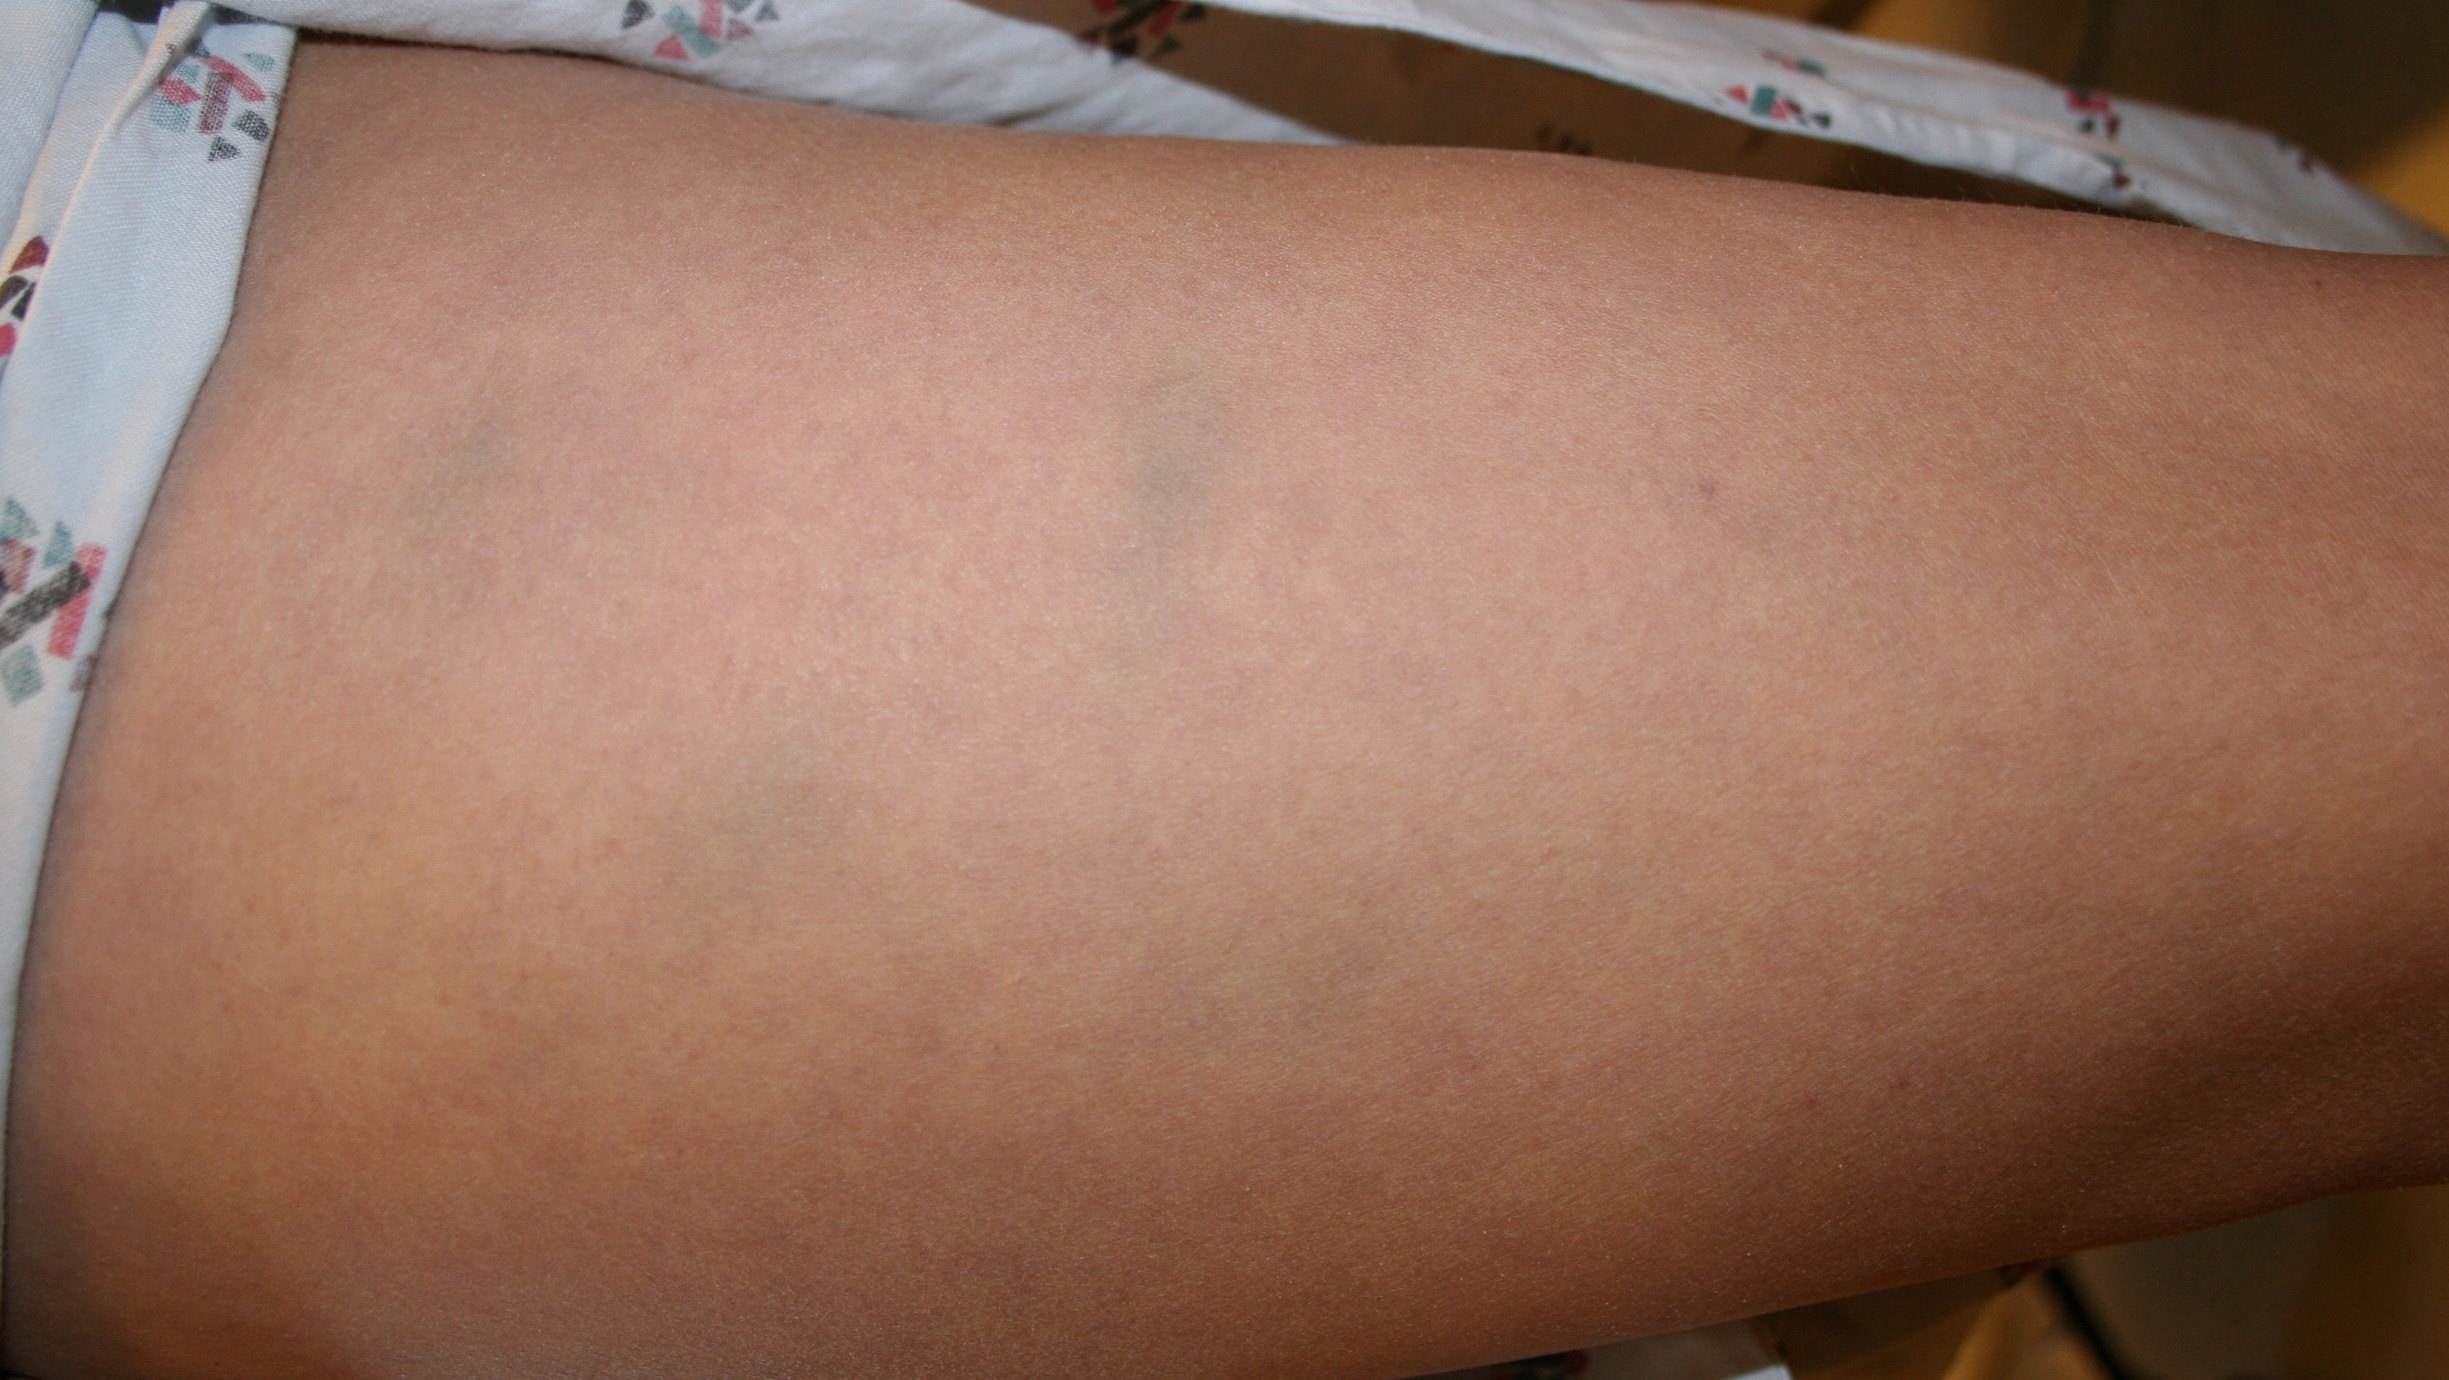

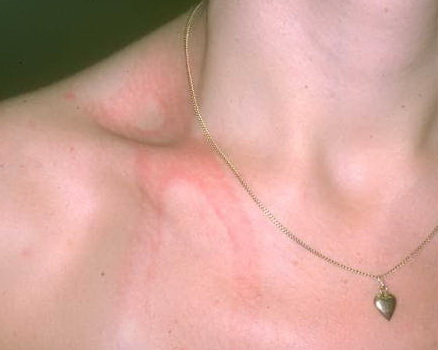

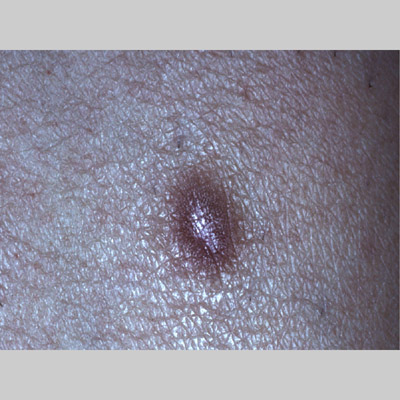

In [55]:
image_paths = df_3['image_path']

# Display 3 images
for path in image_paths[:3]:
    display(Image(filename=path, width=100))

<a id='Encoding-the-categorical-variables'></a>
## 4.2. Encoding categorical variables

Encoding categorical variables is crucial for integrating non-numerical information into CNNs, ensuring compatibility with the model architecture.

In [56]:
one_hot_encode = ['nine_partition_label', 'three_partition_label']

df_3 = pd.get_dummies(df_3, columns=one_hot_encode)

<a id='Encoding-labels'></a>
## 4.3. Encoding labels

The same principle applies here, encoding labels is important to ensure compatibility with the model.

In [57]:
# label encoding
label_encoder = LabelEncoder()

# Encode target labels
labels = label_encoder.fit_transform(df_3['label'].values)

<a id='Split-the-data'></a>
# 5. Split the data

With the features and target variables defined, we will proceed to the data splitting into training and validation sets. We use *'random_state=42'* to ensure reproducibility of the split, and *'stratify=y'* to ensure that the class proportions are maintained in the splits. This is essential for training models and evaluating their performance.

We will split our dataset into 60% for training set, 20% for validation set and 20% for testing set.

Additionally, we've converted the arrays to *float32*, for memory efficiency and also for performance, since this datatype is faster and uses less memory.

In [58]:
df_4 = df_3.copy()

In [59]:
# Define variables for the split
X_meta = df_4.drop(columns=['image_path', 'label'])
images = df_3.image_path
y_labels = labels

# Data split
X_meta_train, X_meta_val, X_image_train, X_image_val, y_train, y_val = train_test_split(
    X_meta, images, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

X_meta_train, X_meta_test, X_image_train, X_image_test, y_train, y_test = train_test_split(
    X_meta_train, X_image_train, y_train, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 (20% validation)

# Convert features to float32, for saving memory
X_meta_train = X_meta_train.astype(np.float32)
X_meta_val = X_meta_val.astype(np.float32)
X_meta_test = X_meta_test.astype(np.float32)

# Print the number of samples in each set
print('Number of training samples:', len(X_meta_train))
print('Metadata (X_meta_train):', X_meta_train.shape)
print('Image paths (X_image_train):', len(X_image_train))
print('Target (y_train):', len(y_train))
print('\n')
print('Number of validation samples:', len(X_meta_val))
print('Metadata (X_meta_val):', X_meta_val.shape)
print('Image paths (X_image_val):', len(X_image_val))
print('Target (y_val):', len(y_val))
print('\n')
print('Number of test samples:', len(X_meta_test))
print('Image paths (X_image_test):', len(X_image_test))
print('Target (y_test):', len(y_test))

Number of training samples: 9919
Metadata (X_meta_train): (9919, 13)
Image paths (X_image_train): 9919
Target (y_train): 9919


Number of validation samples: 3307
Metadata (X_meta_val): (3307, 13)
Image paths (X_image_val): 3307
Target (y_val): 3307


Number of test samples: 3307
Image paths (X_image_test): 3307
Target (y_test): 3307


<a id='Image-preprocessing'></a>
# 6. Image preprocessing

Since we have limited computed resources, we have decided to preprocessed the images after the split, to avoid overload the memory.

Preprocessing is particularly applied for image data and involves various steps. Image resizing is the first step, in ensuring that all images have the same dimension. This standard is necessary to reduce computational complexity and support uniform training. Image stacking is also applied to normalize pixel values into a common range, generally in the range of 0-1.

<a id='Image-array'></a>
## 6.1. Image array

The function *'preprocess_image'* convert the subsets of images on arrays, and also resize them.

In [60]:
def preprocess_image(image_path, target_size):
    """
    Preprocesses the input image by resizing and normalizing its pixel values.

    Inputs:
        image_path (str): The file path of the input image to be preprocessed.
        target_size (tuple): A tuple specifying the target size (height, width) to resize the image.

    Outputs:
        image_array (numpy.ndarray): A numpy array representing the preprocessed image.
    """
    # Load the image using cv2
    image = cv2.imread(image_path)

    # Resize the image
    image_resized = cv2.resize(image, target_size)
    image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # Convert image to float32 and normalize pixel values to [0, 1]
    image_array = image_resized.astype(np.float32) / 255.0

    return image_array

In [61]:
# X_image_train
preprocessed_X_image_train = []

for image_path in X_image_train:
    preprocessed_image = preprocess_image(image_path, target_size=(200, 200))
    preprocessed_image_np = np.array(preprocessed_image)
    preprocessed_X_image_train.append(preprocessed_image_np)

preprocessed_X_image_train = np.array(preprocessed_X_image_train)

In [62]:
# X_image_val
preprocessed_X_image_val = []

for image_path in X_image_val:
    preprocessed_image = preprocess_image(image_path, target_size=(200, 200))
    preprocessed_image_np = np.array(preprocessed_image)
    preprocessed_X_image_val.append(preprocessed_image_np)

preprocessed_X_image_val = np.array(preprocessed_X_image_val)

In [63]:
# X_image_test
preprocessed_X_image_test = []

for image_path in X_image_test:
    preprocessed_image = preprocess_image(image_path, target_size=(200, 200))
    preprocessed_image_np = np.array(preprocessed_image)
    preprocessed_X_image_test.append(preprocessed_image_np)

preprocessed_X_image_test = np.array(preprocessed_X_image_test)

In [64]:
print('The shape of preprocessed_X_image_train:', preprocessed_X_image_train.shape)
print('The shape of preprocessed_X_image_val:', preprocessed_X_image_val.shape)
print('The shape of preprocessed_X_image_test:', preprocessed_X_image_test.shape)

The shape of preprocessed_X_image_train: (9919, 200, 200, 3)
The shape of preprocessed_X_image_val: (3307, 200, 200, 3)
The shape of preprocessed_X_image_test: (3307, 200, 200, 3)


The distribution across labels on the training set and validation set looks unbalanced, so we will apply different techniques to correct this issue.

In [65]:
# Class proportions in the training set
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_class_proportions = train_counts / len(y_train)

# Class proportions in the validation set
val_classes, val_counts = np.unique(y_val, return_counts=True)
val_class_proportions = val_counts / len(y_val)

print('Proportions of classes in training set:')
for cls, prop in zip(train_classes, train_class_proportions):
    print(f"Class {cls}: {prop:.4f}")

print('\nProportions of classes in validation set:')
for cls, prop in zip(val_classes, val_class_proportions):
    print(f"Class {cls}: {prop:.4f}")

Proportions of classes in training set:
Class 0: 0.0065
Class 1: 0.0113
Class 2: 0.0200
Class 3: 0.0039
Class 4: 0.0060
Class 5: 0.0106
Class 6: 0.0249
Class 7: 0.0049
Class 8: 0.0283
Class 9: 0.0039
Class 10: 0.0035
Class 11: 0.0034
Class 12: 0.0052
Class 13: 0.0071
Class 14: 0.0043
Class 15: 0.0094
Class 16: 0.0049
Class 17: 0.0089
Class 18: 0.0040
Class 19: 0.0118
Class 20: 0.0044
Class 21: 0.0049
Class 22: 0.0129
Class 23: 0.0078
Class 24: 0.0052
Class 25: 0.0044
Class 26: 0.0054
Class 27: 0.0030
Class 28: 0.0144
Class 29: 0.0054
Class 30: 0.0036
Class 31: 0.0079
Class 32: 0.0205
Class 33: 0.0059
Class 34: 0.0120
Class 35: 0.0043
Class 36: 0.0104
Class 37: 0.0043
Class 38: 0.0057
Class 39: 0.0040
Class 40: 0.0067
Class 41: 0.0095
Class 42: 0.0102
Class 43: 0.0096
Class 44: 0.0048
Class 45: 0.0036
Class 46: 0.0051
Class 47: 0.0046
Class 48: 0.0295
Class 49: 0.0050
Class 50: 0.0038
Class 51: 0.0250
Class 52: 0.0059
Class 53: 0.0078
Class 54: 0.0063
Class 55: 0.0069
Class 56: 0.0157
C

<a id='Class-balance-techniques'></a>
## 6.2. Class balance techniques

CNNs also require balanced data preprocessing to address the problems with imbalanced datasets. Imbalance issues often occur in class-wise cases where a certain class is more frequently observed than the others in the dataset, which contributes to the performance issues.

In data preprocessing, the CNN models can utilize various strategies, such as oversampling the less frequently observed class and undersampling the more frequent result. In oversampling, artificial copies of the same sample are produced and added to the dataset outweighs it. Undersampling, in turn, involves reducing the more frequently cited examples subsets in the problem.

#### Undersampling the majority classes

Undersampling will help reduce the representation of the classes that have a lot of samples. This way, we get sample to increase the presence of the ones that are less represented.

In [ ]:
# X_meta_train

# Find the classes with counts greater than 100
majority_classes = [label for label, count in Counter(y_train).items() if count > 100]

# Reduction count for each majority class
reduction_counts = {label: int(count * 0.7) for label, count in Counter(y_train).items() if label in majority_classes}

sampling_strategy = {}

# Adjust for majority class, otherwise keep the count unchanged
for label, count in Counter(y_train).items():
    if label in reduction_counts:
        sampling_strategy[label] = count - reduction_counts[label]
    else:
        sampling_strategy[label] = count

# Undersampling
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_meta_train_resampled, y_train_resampled = undersampler.fit_resample(X_meta_train, y_train)

In [ ]:
# X_image_train

# Flatten the preprocessed_X_image_train array
X_image_train_flat = preprocessed_X_image_train.reshape(preprocessed_X_image_train.shape[0], -1)

# Find the classes with counts greater than 100
majority_classes = [label for label, count in Counter(y_train).items() if count > 100]

# Reduction count for each majority class
reduction_counts = {label: int(count * 0.7) for label, count in Counter(y_train).items() if label in majority_classes}

sampling_strategy = {}

# Adjust for majority class, otherwise keep the count unchanged
for label, count in Counter(y_train).items():
    if label in reduction_counts:
        sampling_strategy[label] = count - reduction_counts[label]
    else:
        sampling_strategy[label] = count

# Undersampling
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_image_train_resampled_flat, y_image_train_resampled = undersampler.fit_resample(X_image_train_flat, y_train)

# Reshape the undersampled array back to its original shape
X_image_train_resampled = X_image_train_resampled_flat.reshape(-1, preprocessed_X_image_train.shape[1], preprocessed_X_image_train.shape[2], preprocessed_X_image_train.shape[3])


# Check the class distribution
print('Class distribution before undersampling:', Counter(y_train))
print('Class distribution after undersampling:', Counter(y_train_resampled))

Class distribution before undersampling: Counter({86: 379, 98: 357, 48: 293, 8: 281, 51: 248, 6: 247, 75: 221, 91: 216, 92: 211, 68: 211, 32: 203, 2: 198, 93: 190, 80: 158, 56: 156, 64: 150, 28: 143, 22: 128, 66: 119, 34: 119, 19: 117, 79: 116, 1: 112, 81: 108, 60: 106, 5: 105, 36: 103, 85: 102, 42: 101, 111: 99, 43: 95, 108: 95, 41: 94, 15: 93, 73: 91, 107: 88, 17: 88, 71: 86, 109: 82, 95: 78, 31: 78, 105: 78, 53: 77, 83: 77, 23: 77, 104: 73, 13: 70, 63: 69, 55: 68, 103: 68, 90: 66, 40: 66, 0: 64, 100: 64, 88: 63, 110: 62, 54: 62, 57: 61, 4: 60, 33: 59, 52: 59, 94: 59, 38: 57, 76: 57, 89: 56, 70: 55, 58: 55, 29: 54, 26: 54, 12: 52, 24: 52, 46: 51, 59: 50, 49: 50, 21: 49, 113: 49, 16: 49, 62: 49, 7: 49, 44: 48, 82: 48, 47: 46, 69: 46, 25: 44, 106: 44, 78: 44, 20: 44, 35: 43, 14: 43, 37: 43, 67: 43, 18: 40, 39: 40, 96: 40, 3: 39, 9: 39, 74: 38, 102: 38, 65: 38, 50: 38, 72: 37, 30: 36, 45: 36, 61: 35, 97: 35, 99: 35, 101: 35, 10: 35, 11: 34, 84: 33, 112: 33, 77: 32, 87: 32, 27: 30})
Clas

#### Oversampling the minority classes

Oversampling will enable us to increase the frequence of the classes less represented.

In [ ]:
# X_meta_train_resampled

# Find the minority classes with counts less than 50
minority_classes = [label for label, count in Counter(y_train_resampled).items() if count < 50]

# Oversample count for each minority class
oversample_counts = {label: int(count * 0.9) for label, count in Counter(y_train_resampled).items() if label in minority_classes}

sampling_strategy = {}

# Adjust for minority class, otherwise keep the count unchanged
for label, count in Counter(y_train_resampled).items():
    if label in oversample_counts:
        sampling_strategy[label] = count + oversample_counts[label]
    else:
        sampling_strategy[label] = count

# Oversampling
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_meta_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_meta_train_resampled, y_train_resampled)

In [ ]:
# X_image_train_resampled

# Flatten the preprocessed_X_image_train array
X_image_train_flat = X_image_train_resampled.reshape(X_image_train_resampled.shape[0], -1)

# Find the minority classes with counts less than 50
minority_classes = [label for label, count in Counter(y_train_resampled).items() if count < 50]

# Oversample count for each minority class
oversample_counts = {label: int(count * 0.9) for label, count in Counter(y_train_resampled).items() if label in minority_classes}

sampling_strategy = {}

# Adjust for minority class, otherwise keep the count unchanged
for label, count in Counter(y_train_resampled).items():
    if label in oversample_counts:
        sampling_strategy[label] = count + oversample_counts[label]
    else:
        sampling_strategy[label] = count

# Oversampling
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_image_train_resampled_flat, y_image_train_resampled = oversampler.fit_resample(X_image_train_flat, y_train_resampled)

# Reshape the oversampled array back to its original shape
X_image_train_oversampled = X_image_train_resampled_flat.reshape(-1, X_image_train_resampled.shape[1], X_image_train_resampled.shape[2], X_image_train_resampled.shape[3])

# Check the class distribution
print("Class distribution after oversample:", Counter(y_train_oversampled))

Class distribution after oversample: Counter({86: 114, 98: 108, 111: 99, 43: 95, 108: 95, 41: 94, 7: 93, 15: 93, 16: 93, 21: 93, 62: 93, 113: 93, 44: 91, 73: 91, 80: 91, 82: 91, 56: 89, 17: 88, 48: 88, 107: 88, 47: 87, 69: 87, 71: 86, 8: 85, 64: 85, 20: 83, 25: 83, 78: 83, 106: 83, 109: 82, 14: 81, 28: 81, 35: 81, 37: 81, 67: 81, 31: 78, 95: 78, 105: 78, 23: 77, 53: 77, 83: 77, 18: 76, 39: 76, 96: 76, 6: 75, 51: 75, 3: 74, 9: 74, 22: 74, 104: 73, 50: 72, 65: 72, 74: 72, 102: 72, 13: 70, 72: 70, 63: 69, 19: 68, 30: 68, 34: 68, 45: 68, 55: 68, 66: 68, 103: 68, 75: 67, 10: 66, 40: 66, 61: 66, 79: 66, 90: 66, 97: 66, 99: 66, 101: 66, 91: 65, 0: 64, 1: 64, 11: 64, 68: 64, 92: 64, 100: 64, 88: 63, 54: 62, 81: 62, 84: 62, 110: 62, 112: 62, 32: 61, 57: 61, 2: 60, 4: 60, 5: 60, 60: 60, 77: 60, 87: 60, 33: 59, 52: 59, 94: 59, 36: 58, 42: 58, 85: 58, 27: 57, 38: 57, 76: 57, 93: 57, 89: 56, 58: 55, 70: 55, 26: 54, 29: 54, 12: 52, 24: 52, 46: 51, 49: 50, 59: 50})


Check the shapes of the arrays to verify is the changes went as expected.

In [ ]:
print('The shape of X_image_train_oversampled:', X_image_train_oversampled.shape)
print('The shape of X_meta_train_oversampled:', X_meta_train_oversampled.shape)
print('The shape of y_train_oversampled:', y_train_oversampled.shape)

The shape of X_image_train_oversampled: (8247, 200, 200, 3)
The shape of X_meta_train_oversampled: (8247, 13)
The shape of y_train_oversampled: (8247,)


Now, we verify the proportion distribution of the labels, after all this changes, and we see that most distribution are close to each other. To ensure that all get the same proportion, and also to add more variability to the model, we will apply augmentation.

In [ ]:
unique_labels, label_counts = np.unique(y_train_oversampled, return_counts=True)
total_samples = len(y_train_oversampled)
label_proportions = label_counts / total_samples

for label, proportion in zip(unique_labels, label_proportions):
    print(f"Label {label}: Proportion {proportion:.4f}")

Label 0: Proportion 0.0078
Label 1: Proportion 0.0078
Label 2: Proportion 0.0073
Label 3: Proportion 0.0090
Label 4: Proportion 0.0073
Label 5: Proportion 0.0073
Label 6: Proportion 0.0091
Label 7: Proportion 0.0113
Label 8: Proportion 0.0103
Label 9: Proportion 0.0090
Label 10: Proportion 0.0080
Label 11: Proportion 0.0078
Label 12: Proportion 0.0063
Label 13: Proportion 0.0085
Label 14: Proportion 0.0098
Label 15: Proportion 0.0113
Label 16: Proportion 0.0113
Label 17: Proportion 0.0107
Label 18: Proportion 0.0092
Label 19: Proportion 0.0082
Label 20: Proportion 0.0101
Label 21: Proportion 0.0113
Label 22: Proportion 0.0090
Label 23: Proportion 0.0093
Label 24: Proportion 0.0063
Label 25: Proportion 0.0101
Label 26: Proportion 0.0065
Label 27: Proportion 0.0069
Label 28: Proportion 0.0098
Label 29: Proportion 0.0065
Label 30: Proportion 0.0082
Label 31: Proportion 0.0095
Label 32: Proportion 0.0074
Label 33: Proportion 0.0072
Label 34: Proportion 0.0082
Label 35: Proportion 0.0098
La

#### Augmentation

Data augmentation is a technique applied to enhance data diversity during the training process. Augmented data is more robust and reduces the chances of overfitting. Common augmentation techniques include image rotation, image shifting, and image flipping.

We will apply this final aproach to balance the proportions between classes, and also introduce more variability to the model.

In [ ]:
# ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Combine 'X_meta_train_oversampled' and 'X_image_train_oversampled'
X_train_combined = list(zip(X_meta_train_oversampled, X_image_train_oversampled, y_train_oversampled))


augmented_images = []
augmented_meta_features = []
augmented_labels = []

# Number of samples after augmentation
target_samples_per_class = int(len(y_train_oversampled) * 0.015)

# How many samples each class needs based on the target
unique, counts = np.unique(y_train_oversampled, return_counts=True)
class_needs = {class_label: max(0, target_samples_per_class - count) for class_label, count in zip(unique, counts)}

for class_label, needed_samples in class_needs.items():
    if needed_samples <= 0:
        continue  # Skip classes that don't need augmentation

    # Indices of the current class in the dataset
    class_indices = np.where(y_train_oversampled == class_label)[0]
    print(f'Augmented class: {class_label}')

    # Augment data for this class
    for _ in range(needed_samples):
        idx = np.random.choice(class_indices)
        image_to_augment = X_image_train_oversampled[idx].reshape((1,) + X_image_train_oversampled[idx].shape)
        meta_to_replicate = X_meta_train_oversampled.iloc[idx].values

        # Perform augmentation
        it = train_datagen.flow(image_to_augment, batch_size=1)
        augmented_image = next(it)[0]

        # Append the augmented data
        augmented_images.append(augmented_image)
        augmented_meta_features.append(meta_to_replicate)
        augmented_labels.append(class_label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_meta_features = np.array(augmented_meta_features)
augmented_labels = np.array(augmented_labels)

# Concatenate the original and augmented data
X_image_train_augmented = np.concatenate((X_image_train_oversampled, augmented_images))
X_meta_train_augmented = np.concatenate((X_meta_train_oversampled, augmented_meta_features))
y_train_augmented = np.concatenate((y_train_oversampled, augmented_labels))

Augmented class: 0
Augmented class: 1
Augmented class: 2
Augmented class: 3
Augmented class: 4
Augmented class: 5
Augmented class: 6
Augmented class: 7
Augmented class: 8
Augmented class: 9
Augmented class: 10
Augmented class: 11
Augmented class: 12
Augmented class: 13
Augmented class: 14
Augmented class: 15
Augmented class: 16
Augmented class: 17
Augmented class: 18
Augmented class: 19
Augmented class: 20
Augmented class: 21
Augmented class: 22
Augmented class: 23
Augmented class: 24
Augmented class: 25
Augmented class: 26
Augmented class: 27
Augmented class: 28
Augmented class: 29
Augmented class: 30
Augmented class: 31
Augmented class: 32
Augmented class: 33
Augmented class: 34
Augmented class: 35
Augmented class: 36
Augmented class: 37
Augmented class: 38
Augmented class: 39
Augmented class: 40
Augmented class: 41
Augmented class: 42
Augmented class: 43
Augmented class: 44
Augmented class: 45
Augmented class: 46
Augmented class: 47
Augmented class: 48
Augmented class: 49
Augmented 

In [ ]:
print("Shape of X_image_train_augmented:", X_image_train_augmented.shape)
print("Shape of y_train_augmented:", y_train_augmented.shape)
print("Shape of X_meta_train_augmented:", X_meta_train_augmented.shape)

Shape of X_image_train_augmented: (14022, 200, 200, 3)
Shape of y_train_augmented: (14022,)
Shape of X_meta_train_augmented: (14022, 13)


In [ ]:
# Calculate the proportion of each label in y_train_augmented
unique_labels, label_counts = np.unique(y_train_augmented, return_counts=True)
total_samples = len(y_train_augmented)
label_proportions = label_counts / total_samples

# Check if the class labels are balanced
balanced = np.allclose(label_proportions, np.mean(label_proportions))

if balanced:
    print("Class labels are balanced.")
else:
    print("Class labels are not balanced.")

Class labels are balanced.


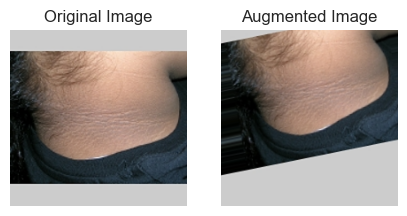

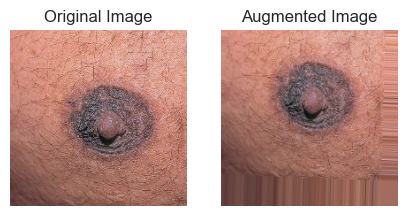

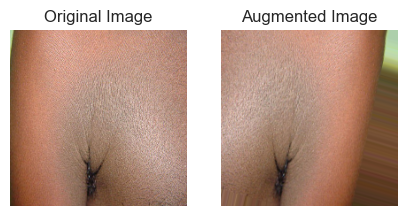

In [ ]:
# Define a function to plot original and augmented images side by side
def plot_images(original_image, augmented_image):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(augmented_image)
    axes[1].set_title('Augmented Image')
    axes[1].axis('off')
    plt.show()

for i in range(3):
    meta_data, image_data, class_label = X_train_combined[i]
    plot_images(image_data, train_datagen.random_transform(image_data))

<a id='Build-the-model'></a>
# 7. Build the model

The structure of the model has two parts: an image branch and a metadata branch, which are later concatenated.

The **image branch**:
* *input image* data follows the target size defined previously, and since it's a color image, has three color channels;
* Convolutional layer - with increasing number of filters, each one followed by a max pooling layer to reduce spatial dimensions;
* Flatten Layer - output a 1D array for use in the dense layers.

The **metadata branch**:
* *metadata input* follows the shape which has 14 features;
* Dense layer - with ReLu activation function that helps mitigate the vanishing gradient problem. The decreasing number of neurons used helps reduce complexity, and helps prevent overfitting;
* Dropout layer - applied on the concatenated data before passing it to the rest of the dense layers.

The **output layer**:
* 114 neurons to output the probabilities for each of the 114 classes, using *'softmax activation'* that outputs probability for multi class classification problems.

The **model compile**:
* uses Adam optimizer that is well suited for problems that have large amount of data.

We've decided to implement a model with and without augmentation to understand the impact of this technique on our specific problem. Also, we have implemented two different model structures very similar, but one with more dense layers than the other, to differencing the influence on the capacity of the model to predict the classes.

<a id='Hyperparameter-Tuning'></a>
## 7.1. Hyperparameter Tuning

The parameters set before the learning process begins, deeply influence the behavior and efficacy of the model. Subsequently, hyperparameter tuning has an important role in optimizing the model's efficacy, but also helps mitigate overfitting and improves computational efficiency.

The **Grid Search** evaluates the performance for each combination of hyperparameters and selects the one that produces the best results.

Since, this process is really computationally expensive, we've selected the parameters that we think that have the most impact in the model. The parameters selected were:
* ***Dropout*** - is an important regularization technique that can significantly reduce overfitting;
* ***Number of filters in the convolutional layers*** - responsible for extract from the image relevant patterns such as edges, textures, shapes, or more complex structures;
* ***Number of neurons in the dense layer*** - responsible for learning complex relationships, and each neuron in the dense layer represents a feature or combination of features learned from the preceding layers.

In [ ]:
# Hyperparameters
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.25, 0.5))
HP_FILTERS = hp.HParam('filters', hp.Discrete([32, 64]))
HP_DENSE_UNITS_1 = hp.HParam('dense_units_1', hp.Discrete([64, 128]))

# Metric
METRIC_ACCURACY = 'accuracy'

# Configuration for hparams
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_DROPOUT, HP_FILTERS, HP_DENSE_UNITS_1],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [ ]:
def create_model(hparams):
    # Image input layer
    image_input = Input(shape=(200, 200, 3), name='image_input')
    image_conv1 = Conv2D(hparams[HP_FILTERS], (3, 3), activation='relu')(image_input)
    image_pool1 = MaxPooling2D((2, 2))(image_conv1)
    image_conv2 = Conv2D(hparams[HP_FILTERS], (3, 3), activation='relu')(image_pool1)
    image_pool2 = MaxPooling2D((2, 2))(image_conv2)
    image_conv3 = Conv2D(hparams[HP_FILTERS], (3, 3), activation='relu')(image_pool2)
    image_pool3 = MaxPooling2D((2, 2))(image_conv3)
    image_conv4 = Conv2D(hparams[HP_FILTERS], (3, 3), activation='relu')(image_pool3)
    image_pool4 = MaxPooling2D((2, 2))(image_conv4)
    image_flatten = Flatten()(image_pool4)

    # Metadata input layer
    metadata_input = Input(shape=(14,), name='metadata_input')
    metadata_dense = Dense(hparams[HP_DENSE_UNITS_1], activation='relu')(metadata_input)

    # Concatenate image and metadata branches
    combined = concatenate([image_flatten, metadata_dense])

    # Add dense layers for further processing
    dense_dropout = Dropout(hparams[HP_DROPOUT])(combined)
    dense1 = Dense(128, activation='relu')(dense_dropout)
    dense2 = Dense(64, activation='relu')(dense1)
    dense3 = Dense(64, activation='relu')(dense2)

    # Output layer
    output = Dense(114, activation='softmax', name='output')(dense3)

    # Define the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# One-hot labels
y_train_encoded = to_categorical(y_train_augmented, num_classes=114)
y_val_encoded = to_categorical(y_val, num_classes=114)

In [ ]:
# Train and evaluate model
def train_test_model(run_dir, hparams):
    # Create model
    model = create_model(hparams)

    model.fit([X_image_train_augmented, X_meta_train_augmented], y_train_encoded, epochs=5, validation_split=0.2)

    # Evaluate model
    _, accuracy = model.evaluate([preprocessed_X_image_val, X_meta_val], y_val_encoded)

    # Log accuracy
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=5)

    return accuracy

In [ ]:
# Hyperparameter tunning
best_accuracy = 0
best_hparams = None
session_num = 0

for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for filters in HP_FILTERS.domain.values:
        for dense_units_1 in HP_DENSE_UNITS_1.domain.values:
            # Dictionary to store current hyperparameter configuration
            hparams = {
                HP_DROPOUT: dropout_rate,
                HP_FILTERS: filters,
                HP_DENSE_UNITS_1: dense_units_1
            }
            run_name = "run-%d" % session_num # Name for trial run
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams}) # Hyperparameters being tested
            accuracy = train_test_model('logs/hparam_tuning/' + run_name, hparams) # Train and test the model with the hyperparameters

            # Update best accuracy and corresponding hyperparameters
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hparams = hparams

            session_num += 1 # Increment counter for trial runs

print('Best accuracy: ', best_accuracy)
print('Best hyperparameters: ', {h.name: best_hparams[h] for h in best_hparams})

--- Starting trial: run-0
{'dropout': 0.25, 'filters': 32, 'dense_units_1': 64}
Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.0249 - loss: 4.5256 - val_accuracy: 0.0029 - val_loss: 4.0528
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.0868 - loss: 3.4656 - val_accuracy: 0.0292 - val_loss: 3.8319
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.1084 - loss: 3.3202 - val_accuracy: 0.0410 - val_loss: 3.7161
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 173ms/step - accuracy: 0.1507 - loss: 3.1666 - val_accuracy: 0.0414 - val_loss: 3.7290
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.1964 - loss: 2.9943 - val_accuracy: 0.0827 - val_loss: 3.6092
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1174 - loss: 3.4219
--- Starting trial: run-1
{'dropout': 0.25, 'filters': 32, 'dense_units_1': 128}
Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 62s 173ms/step - accuracy: 0.0275 - loss: 4.4964 - val_accuracy: 0.0111 - 

<a id='CNN-model-without-augmentation'></a>
## 7.2. CNN model without augmentation

### First model

In [ ]:
# Image input layer
image_input = Input(shape=(200, 200, 3), name='image_input')
image_conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
image_pool1 = MaxPooling2D((2, 2))(image_conv1)

image_conv2 = Conv2D(64, (3, 3), activation='relu')(image_pool1)
image_pool2 = MaxPooling2D((2, 2))(image_conv2)

image_conv3 = Conv2D(128, (3, 3), activation='relu')(image_pool2)
image_pool3 = MaxPooling2D((2, 2))(image_conv3)

image_conv4 = Conv2D(128, (3, 3), activation='relu')(image_pool3)
image_pool4 = MaxPooling2D((2, 2))(image_conv4)

image_flatten = Flatten()(image_pool4)

# Metadata input layer
metadata_input = Input(shape=(13,), name='metadata_input')
metadata_dense = Dense(128, activation='relu')(metadata_input)

# Concatenate image and metadata branches
combined = concatenate([image_flatten, metadata_dense])

# Dense layers
dense_dropout = Dropout(0.25)(combined)
dense1 = Dense(150, activation='relu')(dense_dropout)

# Output layer
output = Dense(114, activation='softmax', name='output')(dense1)


model_1 = Model(inputs=[image_input, metadata_input], outputs=output)

# Optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 198, 198, 32)      │             896 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 99, 99, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 97, 97, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 48, 48, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 46, 46, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 23, 23, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 21, 21, 128)       │         147,584 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 10, 10, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ metadata_input (InputLayer)   │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 12800)             │               0 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           1,792 │ metadata_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 12928)             │               0 │ flatten[0][0], dense[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 12928)             │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 150)               │       1,939,350 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 114)               │          17,21

 Total params: 2,199,188 (8.39 MB)

 Trainable params: 2,199,188 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 50

# Steps per epoch
steps_per_epoch = len(X_meta_train) // batch_size
validation_steps = len(X_meta_val) // batch_size

In [ ]:
# Callbacks
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]  # Stop training if validation loss doesn't improve for 5 epochs

In [ ]:
# Target labels one-hot encoded
y_train_encoded = to_categorical(y_train, num_classes=114)
y_val_encoded = to_categorical(y_val, num_classes=114)

In [ ]:
# Train the model
history = model_1.fit(
    [preprocessed_X_image_train, X_meta_train],
    y_train_encoded,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=([preprocessed_X_image_val, X_meta_val], y_val_encoded),
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
195/198 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step - accuracy: 0.0486 - loss: 4.5412

C:\Users\joaog\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


198/198 ━━━━━━━━━━━━━━━━━━━━ 108s 528ms/step - accuracy: 0.0488 - loss: 4.5388 - val_accuracy: 0.0768 - val_loss: 3.9884
Epoch 2/20


C:\Users\joaog\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


198/198 ━━━━━━━━━━━━━━━━━━━━ 96s 485ms/step - accuracy: 0.1128 - loss: 3.7966 - val_accuracy: 0.1509 - val_loss: 3.3801
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 96s 483ms/step - accuracy: 0.1661 - loss: 3.2566 - val_accuracy: 0.1775 - val_loss: 3.1606
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 97s 488ms/step - accuracy: 0.2156 - loss: 3.0125 - val_accuracy: 0.2174 - val_loss: 3.0409
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 96s 485ms/step - accuracy: 0.2665 - loss: 2.7604 - val_accuracy: 0.2189 - val_loss: 3.0060
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 96s 484ms/step - accuracy: 0.3383 - loss: 2.4545 - val_accuracy: 0.2371 - val_loss: 3.0656
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 96s 483ms/step - accuracy: 0.4244 - loss: 2.1304 - val_accuracy: 0.2455 - val_loss: 3.1799
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 98s 497ms/step - accuracy: 0.5041 - loss: 1.7995 - val_accuracy: 0.2552 - val_loss: 3.4224
Epoch 9/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 96s 486ms/step - accuracy: 0.5982 - loss: 1.4629 - val

#### Plot results

The best value for validation accuracy is: 0.25521621108055115


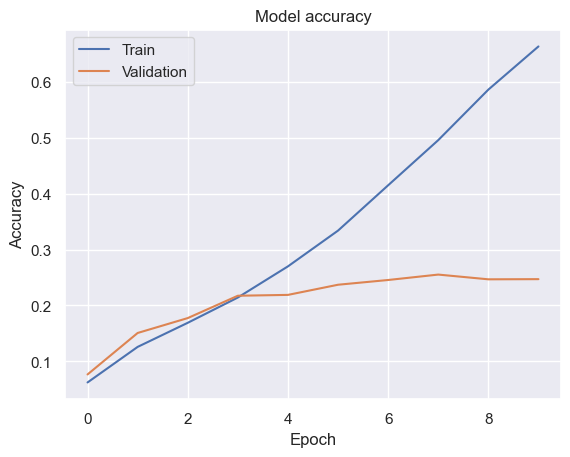

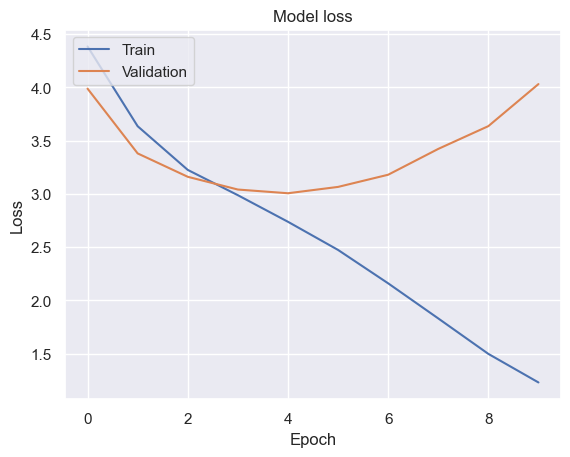

The best value for F1-score is: 0.2925476643024148


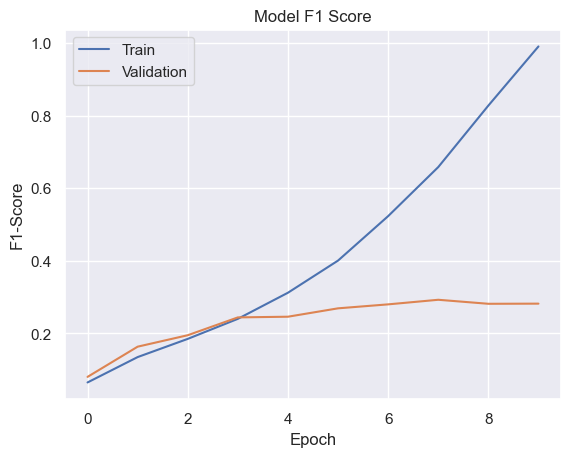

In [ ]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate the F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_1 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_1 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_1)
best_idx = np.argmax(val_f1_scores_1)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_1, label='F1 Score train')
plt.plot(val_f1_scores_1, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Second model

In [ ]:
# Image input layer
image_conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
image_pool1 = MaxPooling2D((2, 2))(image_conv1)

image_conv2 = Conv2D(64, (3, 3), activation='relu')(image_pool1)
image_pool2 = MaxPooling2D((2, 2))(image_conv2)

image_conv3 = Conv2D(128, (3, 3), activation='relu')(image_pool2)
image_pool3 = MaxPooling2D((2, 2))(image_conv3)

image_conv4 = Conv2D(128, (3, 3), activation='relu')(image_pool3)
image_pool4 = MaxPooling2D((2, 2))(image_conv4)
image_flatten = Flatten()(image_pool4)

# Metadata input layer
metadata_input = Input(shape=(13,), name='metadata_input')
metadata_dense = Dense(128, activation='relu')(metadata_input)

# Concatenate image and metadata branches
combined = concatenate([image_flatten, metadata_dense])

# Dense layers
dense_dropout = Dropout(0.25)(combined)  # Dropout before dense layer
dense1 = Dense(128, activation='relu')(dense_dropout)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(64, activation='relu')(dense2)

# Output layer
output = Dense(114, activation='softmax', name='output')(dense3)

model_2 = Model(inputs=[image_input, metadata_input], outputs=output)

# Optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 198, 198, 32)      │             896 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 99, 99, 32)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 97, 97, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 48, 48, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 46, 46, 128)       │          73,856 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 23, 23, 128)       │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 21, 21, 128)       │         147,584 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 10, 10, 128)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ metadata_input (InputLayer)   │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 12800)             │               0 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │           1,792 │ metadata_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 12928)             │               0 │ flatten_1[0][0],           │
│                               │                           │                 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 12928)             │               0 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 128)               │       1,654,91

 Total params: 1,917,362 (7.31 MB)

 Trainable params: 1,917,362 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Steps per epoch
steps_per_epoch = len(X_meta_train) // batch_size
validation_steps = len(X_meta_val) // batch_size

In [ ]:
# Callbacks
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]

In [ ]:
# Target labels one-hot encoded
y_train_encoded = to_categorical(y_train, num_classes=114)
y_val_encoded = to_categorical(y_val, num_classes=114)

In [ ]:
# Train the model
history = model_2.fit(
    [preprocessed_X_image_train, X_meta_train],
    y_train_encoded,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=([preprocessed_X_image_val, X_meta_val], y_val_encoded),
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
195/198 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.0309 - loss: 4.6097

C:\Users\joaog\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


198/198 ━━━━━━━━━━━━━━━━━━━━ 102s 507ms/step - accuracy: 0.0312 - loss: 4.6076 - val_accuracy: 0.0747 - val_loss: 4.0729
Epoch 2/20


C:\Users\joaog\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


198/198 ━━━━━━━━━━━━━━━━━━━━ 99s 501ms/step - accuracy: 0.0775 - loss: 3.8880 - val_accuracy: 0.1418 - val_loss: 3.4721
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 101s 510ms/step - accuracy: 0.1255 - loss: 3.4150 - val_accuracy: 0.1331 - val_loss: 3.3033
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 99s 501ms/step - accuracy: 0.1471 - loss: 3.2676 - val_accuracy: 0.1533 - val_loss: 3.1940
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 98s 496ms/step - accuracy: 0.1638 - loss: 3.1859 - val_accuracy: 0.1727 - val_loss: 3.1336
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 98s 493ms/step - accuracy: 0.1840 - loss: 3.0756 - val_accuracy: 0.1687 - val_loss: 3.0865
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 97s 491ms/step - accuracy: 0.2070 - loss: 2.9902 - val_accuracy: 0.1941 - val_loss: 3.0700
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 99s 499ms/step - accuracy: 0.2268 - loss: 2.9113 - val_accuracy: 0.2008 - val_loss: 3.0310
Epoch 9/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 99s 502ms/step - accuracy: 0.2558 - loss: 2.7741 - va

#### Plot results

The best value for validation accuracy is: 0.229210764169693


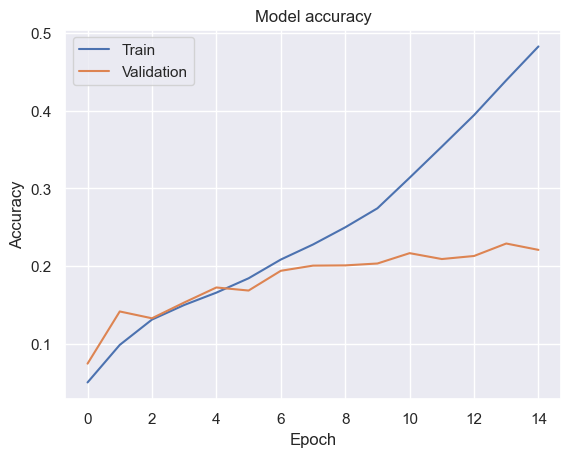

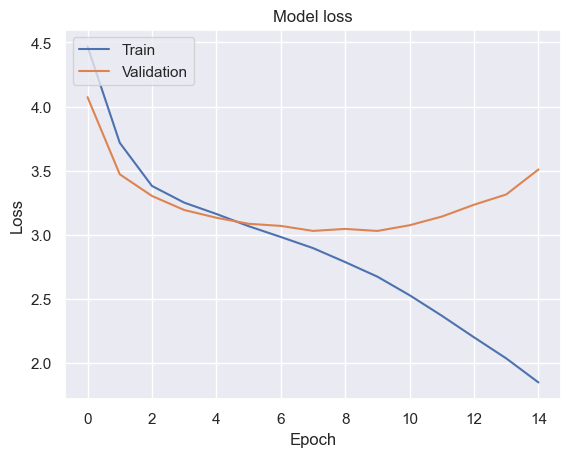

The best value for F1-score is: 0.25887978030566483


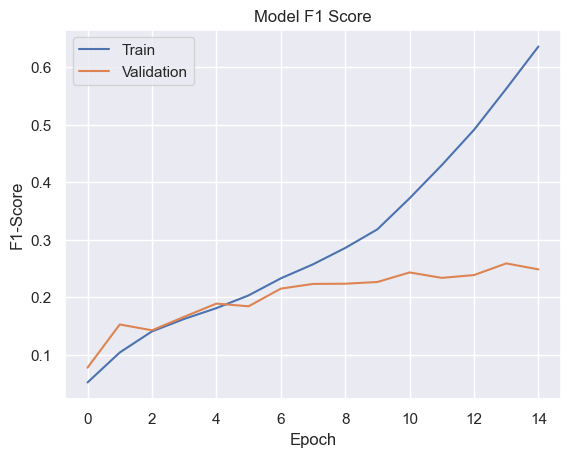

In [ ]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_2 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_2 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_2)
best_idx = np.argmax(val_f1_scores_2)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_2, label='F1 Score train')
plt.plot(val_f1_scores_2, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a id='CNN-model-with-augmentation'></a>
## 7.3. CNN model with augmentation

### First model

In [ ]:
# Image input layer
image_input = Input(shape=(200, 200, 3), name='image_input')
image_conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
image_pool1 = MaxPooling2D((2, 2))(image_conv1)

image_conv2 = Conv2D(64, (3, 3), activation='relu')(image_pool1)
image_pool2 = MaxPooling2D((2, 2))(image_conv2)

image_conv3 = Conv2D(128, (3, 3), activation='relu')(image_pool2)
image_pool3 = MaxPooling2D((2, 2))(image_conv3)

image_conv4 = Conv2D(128, (3, 3), activation='relu')(image_pool3)
image_pool4 = MaxPooling2D((2, 2))(image_conv4)

image_flatten = Flatten()(image_pool4)

# Metadata input layer
metadata_input = Input(shape=(13,), name='metadata_input')
metadata_dense = Dense(128, activation='relu')(metadata_input)

# Concatenate image and metadata branches
combined = concatenate([image_flatten, metadata_dense])

# Dense layers
dense_dropout = Dropout(0.25)(combined)  # Dropout before dense layer
dense1 = Dense(150, activation='relu')(dense_dropout)

# Output layer
output = Dense(114, activation='softmax', name='output')(dense1)

model_3 = Model(inputs=[image_input, metadata_input], outputs=output)

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 198, 198, 32)      │             896 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 99, 99, 32)        │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 97, 97, 64)        │          18,496 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 48, 48, 64)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 46, 46, 128)       │          73,856 │ max_pooling2d_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_10              │ (None, 23, 23, 128)       │               0 │ conv2d_10[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 21, 21, 128)       │         147,584 │ max_pooling2d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_11              │ (None, 10, 10, 128)       │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ metadata_input (InputLayer)   │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 12800)             │               0 │ max_pooling2d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 128)               │           1,792 │ metadata_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 12928)             │               0 │ flatten_2[0][0],           │
│                               │                           │                 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 12928)             │               0 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 150)               │       1,939,35

 Total params: 2,199,188 (8.39 MB)

 Trainable params: 2,199,188 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Steps per epoch
steps_per_epoch = len(X_meta_train_augmented) // batch_size
validation_steps = len(X_meta_val) // batch_size

In [ ]:
# Callbacks
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]

In [ ]:
# Target labels one-hot encoded
y_train_encoded = to_categorical(y_train_augmented, num_classes=114)
y_val_encoded = to_categorical(y_val, num_classes=114)

In [ ]:
# Train the model
history = model_3.fit(
    [X_image_train_augmented, X_meta_train_augmented],
    y_train_encoded,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=([preprocessed_X_image_val, X_meta_val], y_val_encoded),
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 147s 517ms/step - accuracy: 0.0399 - loss: 4.5078 - val_accuracy: 0.1101 - val_loss: 3.5736
Epoch 2/20


C:\Users\joaog\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 476ms/step - accuracy: 0.1460 - loss: 3.3257 - val_accuracy: 0.1388 - val_loss: 3.3524
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 134s 480ms/step - accuracy: 0.2318 - loss: 2.9327 - val_accuracy: 0.1678 - val_loss: 3.3038
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 476ms/step - accuracy: 0.3443 - loss: 2.4767 - val_accuracy: 0.1860 - val_loss: 3.4691
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 475ms/step - accuracy: 0.4706 - loss: 1.9730 - val_accuracy: 0.1935 - val_loss: 3.7715
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 477ms/step - accuracy: 0.6036 - loss: 1.4777 - val_accuracy: 0.1972 - val_loss: 4.4617
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 476ms/step - accuracy: 0.6995 - loss: 1.0976 - val_accuracy: 0.2062 - val_loss: 4.9770
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 132s 473ms/step - accuracy: 0.7765 - loss: 0.8335 - val_accuracy: 0.2074 - val_loss: 5.2338


#### Plot results

The best value for validation accuracy is: 0.20743876695632935


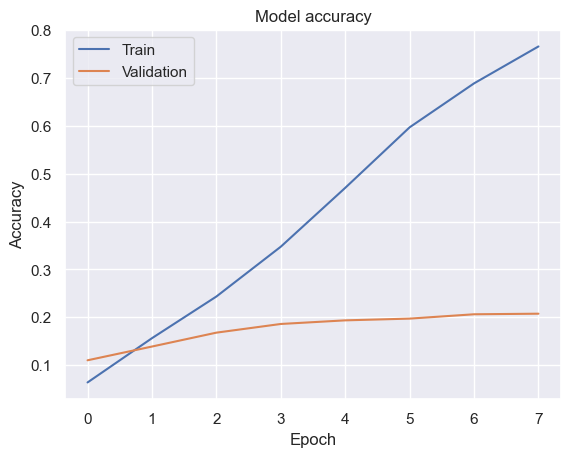

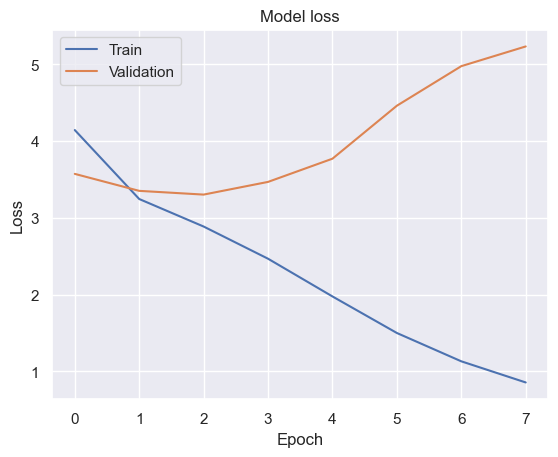

The best value for F1-score is: 0.23144399547691846


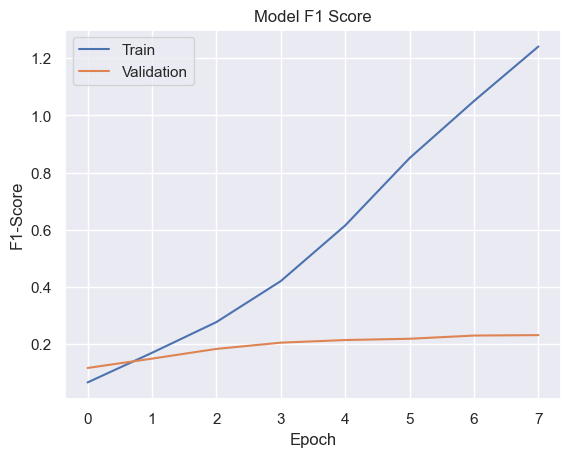

In [ ]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_3 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_3 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_3)
best_idx = np.argmax(val_f1_scores_3)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_3, label='F1 Score train')
plt.plot(val_f1_scores_3, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Second model

In [ ]:
# Image input layer
image_conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
image_pool1 = MaxPooling2D((2, 2))(image_conv1)

image_conv2 = Conv2D(64, (3, 3), activation='relu')(image_pool1)
image_pool2 = MaxPooling2D((2, 2))(image_conv2)

image_conv3 = Conv2D(128, (3, 3), activation='relu')(image_pool2)
image_pool3 = MaxPooling2D((2, 2))(image_conv3)

image_conv4 = Conv2D(128, (3, 3), activation='relu')(image_pool3)
image_pool4 = MaxPooling2D((2, 2))(image_conv4)
image_flatten = Flatten()(image_pool4)

# Metadata input layer
metadata_input = Input(shape=(13,), name='metadata_input')
metadata_dense = Dense(128, activation='relu')(metadata_input)

# Concatenate image and metadata branches
combined = concatenate([image_flatten, metadata_dense])

# Dense layers
dense_dropout = Dropout(0.25)(combined)  # Dropout before dense layer
dense1 = Dense(128, activation='relu')(dense_dropout)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(64, activation='relu')(dense2)

# Output layer
output = Dense(114, activation='softmax', name='output')(dense3)

model_4 = Model(inputs=[image_input, metadata_input], outputs=output)

# Optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 198, 198, 32)      │             896 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 99, 99, 32)        │               0 │ conv2d_12[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 97, 97, 64)        │          18,496 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_13              │ (None, 48, 48, 64)        │               0 │ conv2d_13[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 46, 46, 128)       │          73,856 │ max_pooling2d_13[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_14              │ (None, 23, 23, 128)       │               0 │ conv2d_14[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 21, 21, 128)       │         147,584 │ max_pooling2d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 10, 10, 128)       │               0 │ conv2d_15[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ metadata_input (InputLayer)   │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 12800)             │               0 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 128)               │           1,792 │ metadata_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 12928)             │               0 │ flatten_3[0][0],           │
│                               │                           │                 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 12928)             │               0 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 128)               │       1,654,91

 Total params: 1,917,362 (7.31 MB)

 Trainable params: 1,917,362 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Steps per epoch
steps_per_epoch = len(X_meta_train_augmented) // batch_size
validation_steps = len(X_meta_val) // batch_size

In [ ]:
# Callbacks
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]

In [ ]:
# Target labels one-hot encoded
y_train_encoded = to_categorical(y_train_augmented, num_classes=114)
y_val_encoded = to_categorical(y_val, num_classes=114)

In [ ]:
# Train the model
history = model_4.fit(
    [X_image_train_augmented, X_meta_train_augmented],
    y_train_encoded,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=([preprocessed_X_image_val, X_meta_val], y_val_encoded),
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 152s 530ms/step - accuracy: 0.0223 - loss: 4.5508 - val_accuracy: 0.0575 - val_loss: 3.6758
Epoch 2/20


C:\Users\joaog\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


280/280 ━━━━━━━━━━━━━━━━━━━━ 134s 477ms/step - accuracy: 0.0810 - loss: 3.4990 - val_accuracy: 0.1028 - val_loss: 3.4440
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 134s 477ms/step - accuracy: 0.1254 - loss: 3.3023 - val_accuracy: 0.1173 - val_loss: 3.3806
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 476ms/step - accuracy: 0.1490 - loss: 3.1444 - val_accuracy: 0.1430 - val_loss: 3.3256
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 474ms/step - accuracy: 0.2127 - loss: 2.9475 - val_accuracy: 0.1588 - val_loss: 3.2948
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 132s 473ms/step - accuracy: 0.2543 - loss: 2.7730 - val_accuracy: 0.1848 - val_loss: 3.2792
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 133s 473ms/step - accuracy: 0.3126 - loss: 2.5763 - val_accuracy: 0.1739 - val_loss: 3.3796
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 132s 472ms/step - accuracy: 0.3660 - loss: 2.3340 - val_accuracy: 0.1920 - val_loss: 3.4333
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 134s 480ms/step - accuracy: 0.4308 - loss: 2.08

#### Plot results

The best value for validation accuracy is: 0.20078621804714203


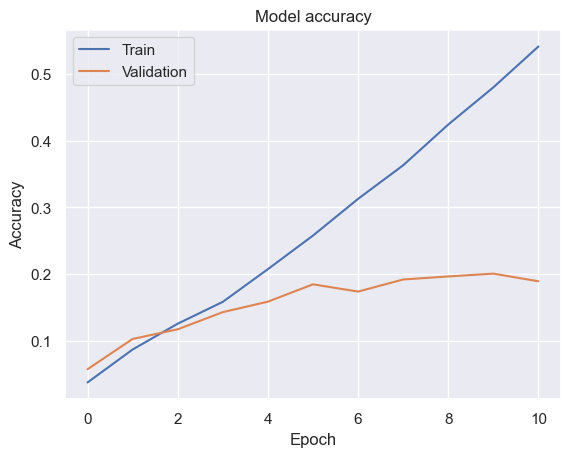

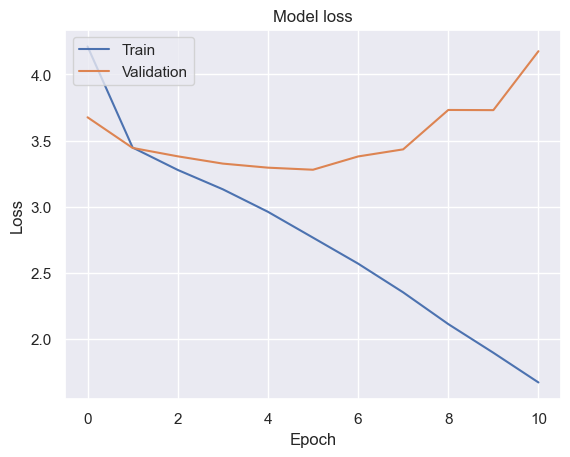

The best value for F1-score is: 0.22319328593538187


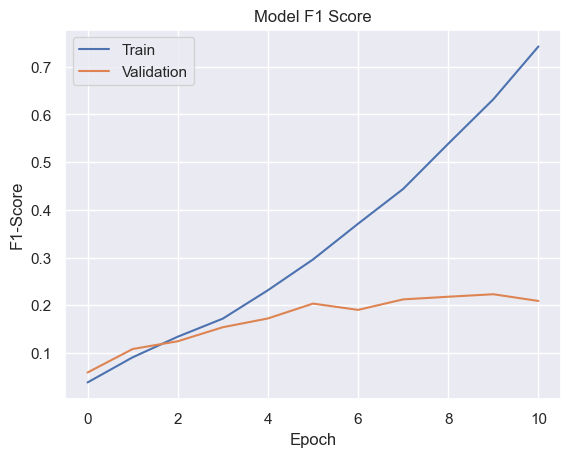

In [ ]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_4 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_4 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_4)
best_idx = np.argmax(val_f1_scores_4)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_4, label='F1 Score train')
plt.plot(val_f1_scores_4, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a id='CNN-pre-trained-model-without-augmentation'></a>
## 7.4. CNN pre-trained model without augmentation

The pre-trained models have several advantages, such as being easy implementation, and helps saving training time and resources. There are many pre-trained models available on TensorFlow, and we will test some examples.

In [66]:
y_train_encoded = to_categorical(y_train, num_classes=114)
y_val_encoded = to_categorical(y_val, num_classes=114)

In [67]:
def build_model_and_fit(pre_trained_model, preprocess_layer, use_augmentation=False, layers_to_train=0):
    """
    Builds a neural network model with optional data augmentation and pre-trained layers, and fits it to the data.

    Inputs:
        pre_trained_model (keras.Model): Pre-trained neural network model.
        preprocess_layer (keras.Layer): Preprocessing layer for input data.
        use_augmentation (bool, optional): Whether to use data augmentation. Defaults to False.
        layers_to_train (int, optional): Number of layers to train in the pre-trained model. Defaults to 0.

    Outputs:
        History: Object containing training history.
    """

    batch_size = 25

    # Steps per epoch
    steps_per_epoch = len(X_meta_train) // batch_size
    validation_steps = len(X_meta_val) // batch_size

    pre_trained_model.trainable = False

    if layers_to_train != 0:
        pre_trained_model.trainable = True
        for layer in pre_trained_model.layers[:-layers_to_train]:
            layer.trainable = False

    # Create data augmentation layers if enabled
    augmentation_layers = []
    if use_augmentation:
        augmentation_layers.extend([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2)
        ])

    data_augmentation = keras.Sequential(augmentation_layers)

    image_input = keras.Input(shape=(200, 200, 3))
    x = image_input
    if use_augmentation:
        x = data_augmentation(x)
    x = keras.layers.Lambda(lambda x: preprocess_layer(x))(x)
    x = pre_trained_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(200)(x)
    image_flatten = layers.Dropout(0.5)(x)

    # Metadata input layer
    metadata_input = Input(shape=(13,), name='metadata_input')
    metadata_dense = Dense(200, activation='relu')(metadata_input)

    combined = concatenate([image_flatten, metadata_dense])

    dense1 = Dense(128, activation='relu')(combined)
    dense2 = Dense(64, activation='relu')(dense1)
    dense3 = Dense(64, activation='relu')(dense2)

    outputs = layers.Dense(114, activation="softmax")(dense3)

    model = keras.Model([image_input, metadata_input], outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    callbacks = [EarlyStopping(patience=5, monitor='val_loss')]

    history = model.fit(
        x=[preprocessed_X_image_train, X_meta_train],
        y=y_train_encoded,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=([preprocessed_X_image_val, X_meta_val], y_val_encoded),
        validation_steps=validation_steps,
        callbacks=callbacks,
        batch_size=batch_size
    )

    return history

### VGG16

VGG16 stands for Visual Geometry Group 16, a convolutional neural network architecture created by the Visual Geometry Group at Oxford University. Published in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”, VGG16 is well-known for its simplicity yet effectiveness.

Having 16 layers, including convolutional and fully connected layers with small 3×3-sized convolutional filters and max-pooling afterwards, its output proved to be highly accurate. VGG16 scored the best object localization results at the ImageNet dataset in the ILSVRC 2014 . Therefore, VGG16 not only can extract meaningful features from images but has various applications to perform multiple computer vision tasks.

*Reference:*
- Simonyan, K., & Zisserman, A. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition.

In [68]:
# Define pre-trained model
conv_base_vgg16 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(200, 200, 3))
conv_base_vgg16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [69]:
history = build_model_and_fit(conv_base_vgg16, keras.applications.vgg16.preprocess_input)

Epoch 1/20
396/396 [==============================] - 42s 88ms/step - loss: 4.6584 - accuracy: 0.0288 - val_loss: 4.5069 - val_accuracy: 0.0397
Epoch 2/20
396/396 [==============================] - 35s 83ms/step - loss: 4.1936 - accuracy: 0.0693 - val_loss: 3.6968 - val_accuracy: 0.1124
Epoch 3/20
396/396 [==============================] - 33s 85ms/step - loss: 3.5358 - accuracy: 0.1036 - val_loss: 3.3864 - val_accuracy: 0.1233
Epoch 4/20
396/396 [==============================] - 34s 85ms/step - loss: 3.3509 - accuracy: 0.1303 - val_loss: 3.2927 - val_accuracy: 0.1379
Epoch 5/20
396/396 [==============================] - 33s 84ms/step - loss: 3.2979 - accuracy: 0.1324 - val_loss: 3.3027 - val_accuracy: 0.1403
Epoch 6/20
396/396 [==============================] - 33s 85ms/step - loss: 3.2740 - accuracy: 0.1349 - val_loss: 3.2557 - val_accuracy: 0.1461
Epoch 7/20
396/396 [==============================] - 33s 84ms/step - loss: 3.2616 - accuracy: 0.1382 - val_loss: 3.2286 - val_accuracy:

#### Plot results

The best value for validation accuracy is: 0.15636363625526428


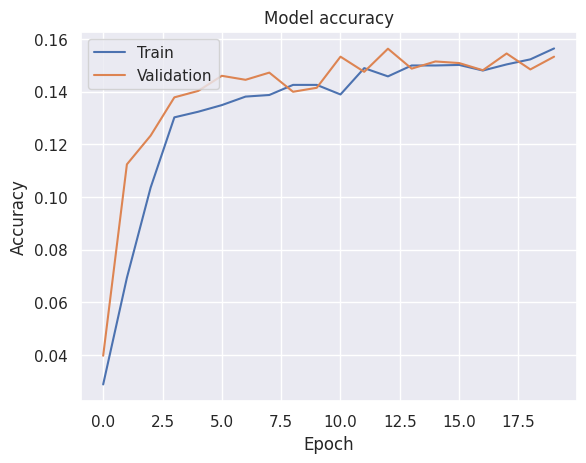

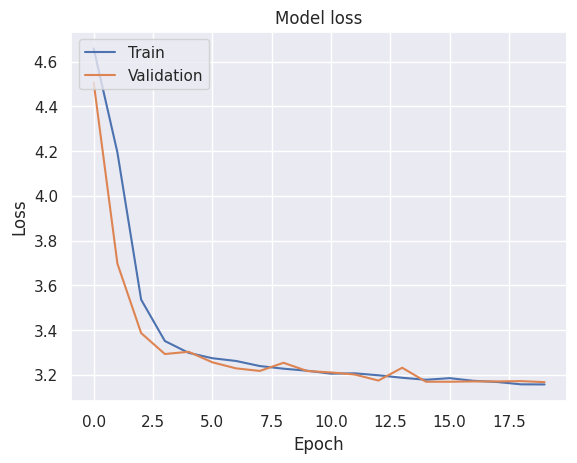

The best value for F1-score is: 0.16962524642078922


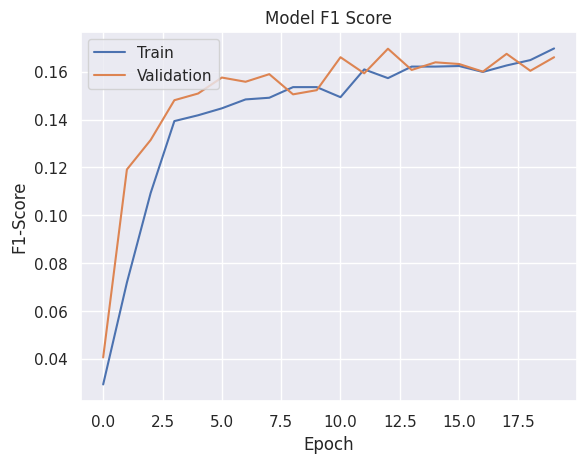

In [78]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_5 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_5 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_5)
best_idx = np.argmax(val_f1_scores_5)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_5, label='F1 Score train')
plt.plot(val_f1_scores_5, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### ResNet50

ResNet50 is short for Residual Network with 50 layers. It is a deep convolutional neural network architecture proposed by Microsoft Research.

These architecture contains 50 layers, which are composed of convolutional, pooling, and fully connected layers. The skipping layers or skip connections are layers that transfer their input directly to the output. One or more of the layers can be skipped. This sharply decreased the problem of gradient disappearing and enabled training networks with hundreds of layers.

Consequently, ResNet50 is one of the key neural architectures for computer vision research, such as image classification, object detection and image segmentation and was the winner of the ILSVRC 2015 classification competition due to its superior performance.

*Reference:*
- He, K., et.al (2016). Deep Residual Learning for Image Recognition.

In [79]:
# Define pre-trained model
conv_base_resnet50 = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(200, 200, 3))
conv_base_resnet50.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [80]:
history = build_model_and_fit(conv_base_resnet50, keras.applications.resnet.preprocess_input)

Epoch 1/20
396/396 [==============================] - 28s 58ms/step - loss: 4.8531 - accuracy: 0.0205 - val_loss: 4.5918 - val_accuracy: 0.0285
Epoch 2/20
396/396 [==============================] - 21s 51ms/step - loss: 4.5807 - accuracy: 0.0349 - val_loss: 4.5698 - val_accuracy: 0.0397
Epoch 3/20
396/396 [==============================] - 20s 51ms/step - loss: 4.5431 - accuracy: 0.0388 - val_loss: 4.5152 - val_accuracy: 0.0397
Epoch 4/20
396/396 [==============================] - 20s 51ms/step - loss: 4.4849 - accuracy: 0.0469 - val_loss: 4.3230 - val_accuracy: 0.0739
Epoch 5/20
396/396 [==============================] - 20s 51ms/step - loss: 4.1973 - accuracy: 0.0681 - val_loss: 3.9690 - val_accuracy: 0.0733
Epoch 6/20
396/396 [==============================] - 20s 51ms/step - loss: 3.7796 - accuracy: 0.0933 - val_loss: 3.5397 - val_accuracy: 0.1070
Epoch 7/20
396/396 [==============================] - 20s 51ms/step - loss: 3.4835 - accuracy: 0.1107 - val_loss: 3.3933 - val_accuracy:

#### Plot results

The best value for validation accuracy is: 0.15212121605873108


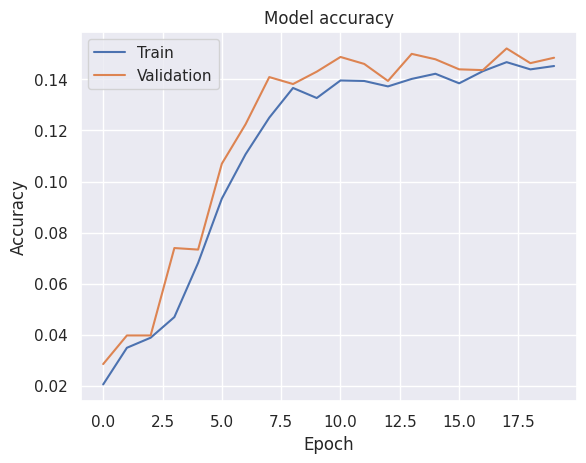

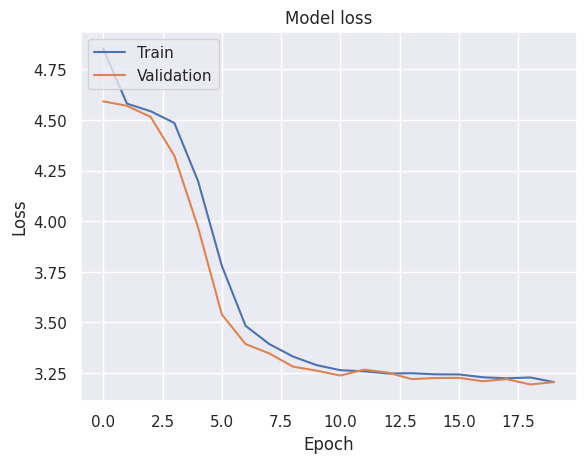

The best value for F1-score is: 0.16464415023400794


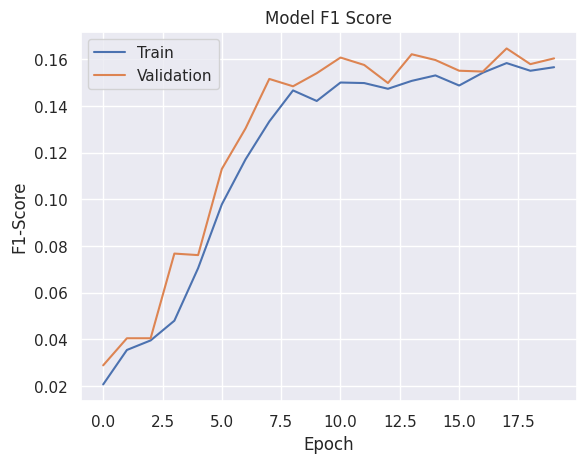

In [82]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_6 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_6 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_6)
best_idx = np.argmax(val_f1_scores_6)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_6, label='F1 Score train')
plt.plot(val_f1_scores_6, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### MobileNet

MobileNet is a convolutional neural network architecture optimized for mobile and embedded vision problems. It is developed by Google and uses depthwise separable convolutions to minimize computational complexity while still achieving high performance in vision-related tasks such as image classification, object detection, and semantic segmentation.

MobileNet is distinguished by its lightweight design, which allows it to be run in a resource-constrained environment.

*Reference:*
- Howard, A. et.al (2017). MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.

In [83]:
# Define pre-trained model
conv_base_mobilenet = keras.applications.MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=(200, 200, 3))
conv_base_mobilenet.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [84]:
history = build_model_and_fit(conv_base_mobilenet, keras.applications.mobilenet.preprocess_input)

Epoch 1/20
396/396 [==============================] - 14s 27ms/step - loss: 4.6119 - accuracy: 0.0308 - val_loss: 4.4422 - val_accuracy: 0.0685
Epoch 2/20
396/396 [==============================] - 8s 20ms/step - loss: 4.2805 - accuracy: 0.0472 - val_loss: 4.0940 - val_accuracy: 0.0791
Epoch 3/20
396/396 [==============================] - 8s 20ms/step - loss: 3.8525 - accuracy: 0.0822 - val_loss: 3.6583 - val_accuracy: 0.1009
Epoch 4/20
396/396 [==============================] - 8s 20ms/step - loss: 3.5922 - accuracy: 0.1062 - val_loss: 3.4977 - val_accuracy: 0.1318
Epoch 5/20
396/396 [==============================] - 8s 20ms/step - loss: 3.4618 - accuracy: 0.1237 - val_loss: 3.3924 - val_accuracy: 0.1327
Epoch 6/20
396/396 [==============================] - 8s 20ms/step - loss: 3.3931 - accuracy: 0.1237 - val_loss: 3.3780 - val_accuracy: 0.1279
Epoch 7/20
396/396 [==============================] - 8s 20ms/step - loss: 3.3615 - accuracy: 0.1260 - val_loss: 3.3426 - val_accuracy: 0.132

#### Plot results

The best value for validation accuracy is: 0.15939393639564514


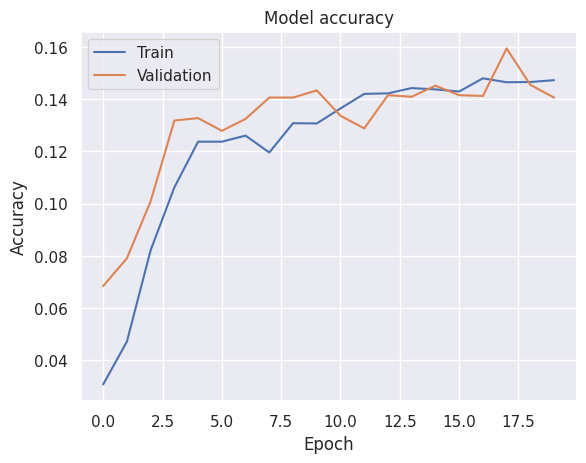

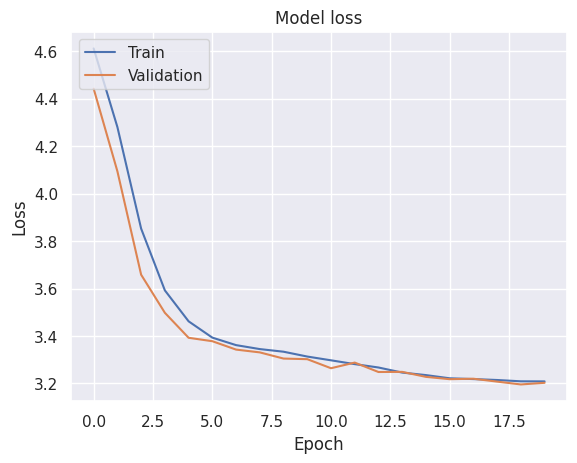

The best value for F1-score is: 0.17319723057253544


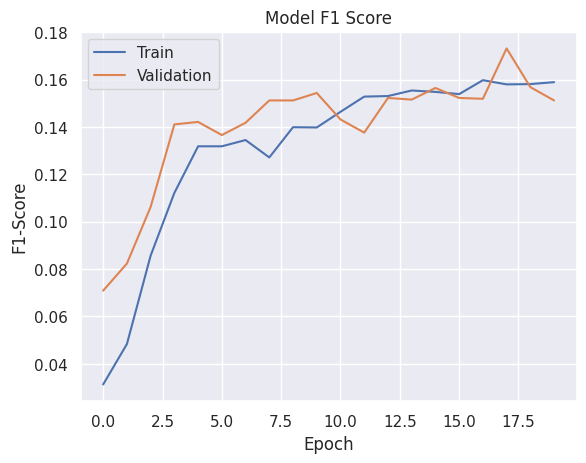

In [85]:
# Best Accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("The best value for validation accuracy is:", best_val_accuracy)

# Accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate F1 Score
# Convert accuracy to error rate
val_error_rate_values = 1 - np.array(history.history['val_accuracy'])
train_error_rate_values = 1 - np.array(history.history['accuracy'])

# Convert error rate to F1 scores
val_f1_scores_7 = 2 * (1 - val_error_rate_values) / (1 + val_error_rate_values)
train_f1_scores_7 = 2 * (1 - train_error_rate_values) / (1 + train_error_rate_values)

# Best F1 Score
max_f1_score = np.max(val_f1_scores_7)
best_idx = np.argmax(val_f1_scores_7)
print("The best value for F1-score is:", max_f1_score)

# F1 scores
plt.plot(train_f1_scores_7, label='F1 Score train')
plt.plot(val_f1_scores_7, label='F1 Score validation')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Model F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a id='Results-discussion'></a>
# 8. Results discussion

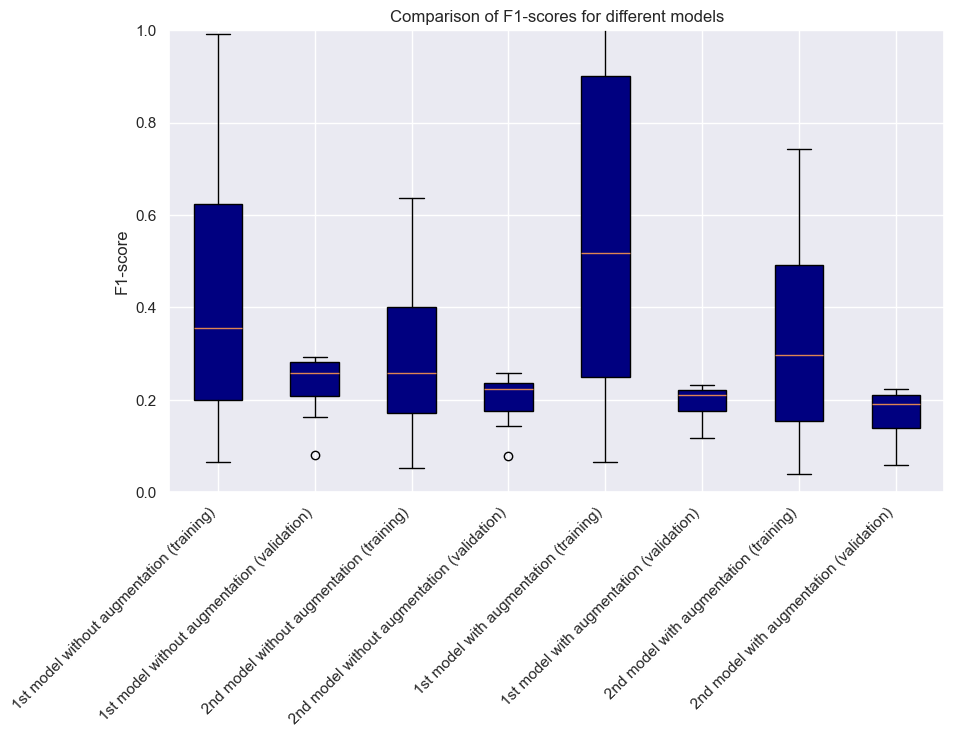

In [ ]:
# For "handmade" models
f1_scores_dict = {'1st model without augmentation (training)': train_f1_scores_1,
                  '1st model without augmentation (validation)': val_f1_scores_1,
                  '2nd model without augmentation (training)': train_f1_scores_2,
                  '2nd model without augmentation (validation)': val_f1_scores_2,
                  '1st model with augmentation (training)': train_f1_scores_3,
                  '1st model with augmentation (validation)': val_f1_scores_3,
                  '2nd model with augmentation (training)': train_f1_scores_4,
                  '2nd model with augmentation (validation)': val_f1_scores_4
}

# Extract models and F1-scores
models = list(f1_scores_dict.keys())
f1_scores = list(f1_scores_dict.values())

plt.figure(figsize=(10, 6))
plt.boxplot(f1_scores, labels=models, patch_artist=True, boxprops=dict(facecolor="navy"))
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores for different models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.show()

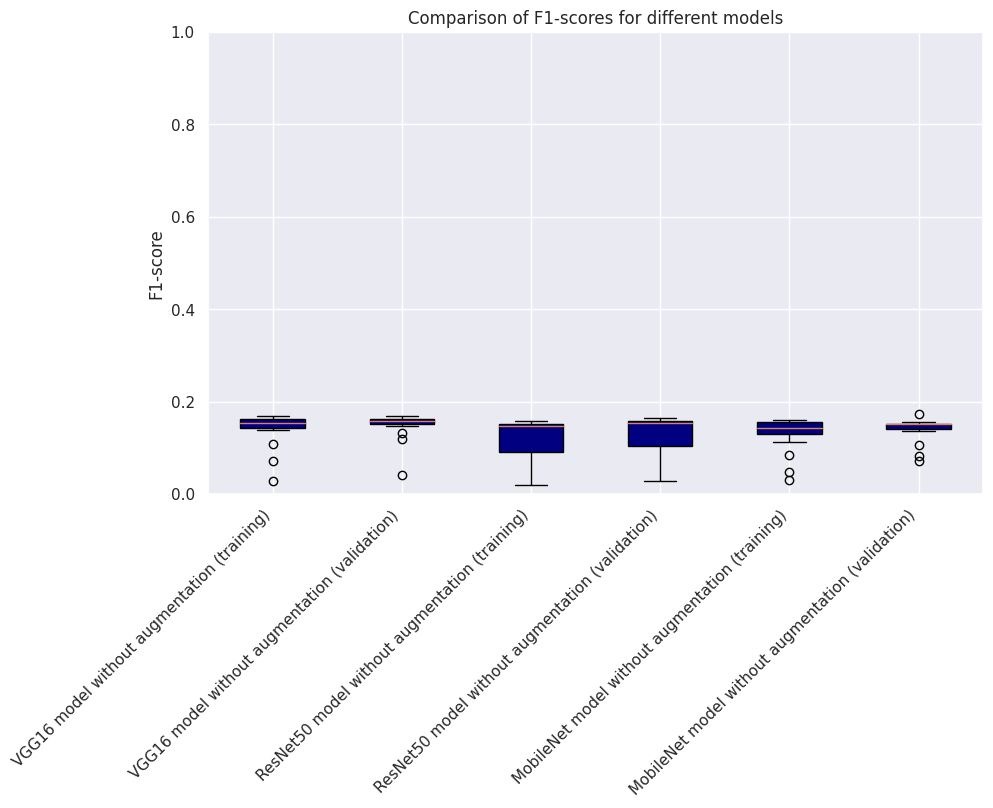

In [86]:
# For pre trainded models
f1_scores_dict = {'VGG16 model without augmentation (training)': train_f1_scores_5,
                  'VGG16 model without augmentation (validation)': val_f1_scores_5,
                  'ResNet50 model without augmentation (training)': train_f1_scores_6,
                  'ResNet50 model without augmentation (validation)': val_f1_scores_6,
                  'MobileNet model without augmentation (training)': train_f1_scores_7,
                  'MobileNet model without augmentation (validation)': val_f1_scores_7
}

# Extract models and F1-scores
models = list(f1_scores_dict.keys())
f1_scores = list(f1_scores_dict.values())

plt.figure(figsize=(10, 6))
plt.boxplot(f1_scores, labels=models, patch_artist=True, boxprops=dict(facecolor="navy"))
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores for different models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.show()

The overall conclusion is that the "handmade" model without augmentation is the one with better capacity to generalize to unseen data. Therefore, we will use this model to predict on the test set, that has a F1-score of approximately 0,29 on validation set.

#### Saliency Map

Saliency maps highlight the regions in an image that contribute the most to the model's prediction.

*Reference*
- https://www.geeksforgeeks.org/what-is-saliency-map/https://keras.io/examples/vision/grad_cam/

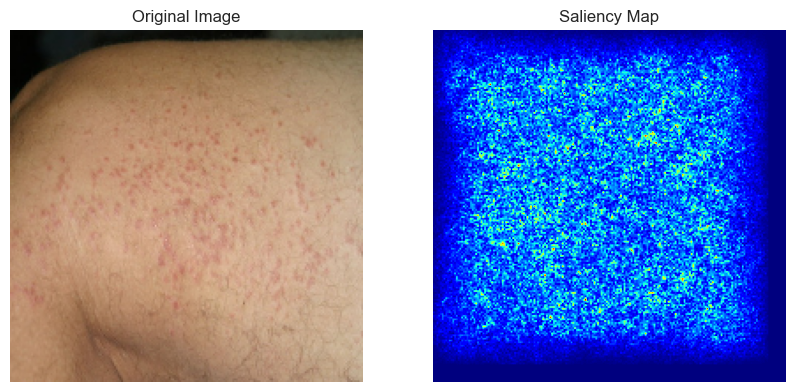

In [ ]:
def generate_saliency_map(model, img, metadata):
    """
    Generate Saliency Map for a given image and model.

    Inputs:
        model (tf.keras.Model): The trained model.
        img (numpy.ndarray): Preprocessed image data as a numpy array with shape (1, height, width, channels).
        metadata (numpy.ndarray): Metadata information for the image as a numpy array with shape (1, num_metadata_features).

    Outputs:
        saliency_map (numpy.ndarray): Saliency map highlighting regions contributing to the model's prediction.
    """
    # Convert the input image to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img)

    # Convert metadata to a TensorFlow tensor
    metadata_tensor = tf.convert_to_tensor(metadata)

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input image tensor
        tape.watch(img_tensor)

        prediction = model([img_tensor, metadata_tensor])

        predicted_class_score = prediction[:, np.argmax(prediction[0])]

    # Gradient of the predicted class score with respect to the input image
    gradient = tape.gradient(predicted_class_score, img_tensor)

    # Absolute gradient values
    abs_gradient = tf.abs(gradient)

    # Normalize the gradient values
    max_abs_gradient = tf.reduce_max(abs_gradient)
    normalized_gradient = abs_gradient / max_abs_gradient

    # Convert the normalized gradient to a saliency map
    saliency_map = tf.reduce_max(normalized_gradient, axis=-1)

    return saliency_map.numpy()

# Image from test set
index = 0
img = np.expand_dims(preprocessed_X_image_test[index], axis=0)
metadata = X_meta_test.iloc[index].values.reshape(1, -1)

# Generate CAM
cam = generate_saliency_map(model_1, img, metadata)

# Plot the original image and its CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam[0], cmap='jet')
plt.title('Saliency Map')
plt.axis('off')

plt.show()

In the particular case, the middle of the image is contributing the most to the model's prediction, while the margins are considered less important.

#### Predictions

Just for example, we will print the first 10 predictions of the model.

In [ ]:
predictions = model_1.predict([preprocessed_X_image_test, X_meta_test]) # Probabilities for each class

predicted_classes = predictions.argmax(axis=1) # Predicted class indices

# Map label indices to string labels using a label encoder
label_encoder = LabelEncoder()
label_encoder.fit(df_3['label'].values)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Print the first 10 predicted class indices, labels, and corresponding probabilities
for i in range(min(10, len(predicted_classes))):
    print(f"Predicted class index: {predicted_classes[i]}, Predicted label: {predicted_labels[i]}, Probability: {predictions[i][predicted_classes[i]]}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step
Predicted class index: 104, Predicted label: syringoma, Probability: 0.4107081890106201
Predicted class index: 83, Predicted label: porphyria, Probability: 0.14944413304328918
Predicted class index: 5, Predicted label: actinic keratosis, Probability: 0.638315737247467
Predicted class index: 81, Predicted label: porokeratosis actinic, Probability: 0.6662988662719727
Predicted class index: 51, Predicted label: lupus erythematosus, Probability: 0.8732548356056213
Predicted class index: 69, Predicted label: nevocytic nevus, Probability: 0.9668034315109253
Predicted class index: 69, Predicted label: nevocytic nevus, Probability: 0.6938162446022034
Predicted class index: 98, Predicted label: squamous cell carcinoma, Probability: 0.45621323585510254
Predicted class index: 75, Predicted label: photodermatoses, Probability: 0.6277346014976501
Predicted class index: 86, Predicted label: psoriasis, Probability: 0.37539368867874146


In [ ]:
# Calculate F1-score
f1 = f1_score(y_test, predicted_classes, average='weighted')

print('The F1-score weighted for the test set is', f1)

The F1-score weighted for the test set is 0.2225471992771348
